In [1]:
import sys, os, pygmt, importlib, re, time, glob
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox      import SeaIceToolbox, SeaIceToolboxManager
from datetime             import timedelta, date, datetime
from pathlib              import Path
from dask.distributed     import Client, LocalCluster
from dask.diagnostics     import ProgressBar
from pyproj               import CRS, Transformer
from collections          import defaultdict
from scipy.interpolate    import interp1d
from tqdm                 import tqdm        
import numpy                as np
import pandas               as pd
import xarray               as xr
import xesmf                as xe
import matplotlib.pyplot    as plt
import matplotlib.dates     as mdates
import matplotlib.animation as animation
from IPython.display      import Image, HTML, Video
import warnings
warnings.filterwarnings("ignore", message="Sending large graph of size", category=UserWarning, module="distributed.client")

In [22]:
import sys
import importlib
for mod in list(sys.modules):
    if mod.startswith("sea_ice_toolbox") or mod.startswith("sea_ice_"):
        del sys.modules[mod]
import sea_ice_plotter
import sea_ice_classification
import sea_ice_icebergs
import sea_ice_observations
import sea_ice_metrics
import sea_ice_toolbox
importlib.reload(sea_ice_plotter)
importlib.reload(sea_ice_classification)
importlib.reload(sea_ice_icebergs)
importlib.reload(sea_ice_observations)
importlib.reload(sea_ice_metrics)
importlib.reload(sea_ice_toolbox)
from sea_ice_toolbox import SeaIceToolbox, SeaIceToolboxManager

In [2]:
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SIA_dict    = {}
SIV_dict    = {}
G_CMEMS     = xr.open_dataset("/g/data/gv90/da1339/grids/GLORYS/CMEMS_0p083_grid.nc")
x_dist      = G_CMEMS['e1t'].load()
y_dist      = G_CMEMS['e2t'].load()
ORAS_A      = x_dist * y_dist
ORAS_A_SH   = ORAS_A.isel(latitude=slice(0,1020))
ORAS_A_da   = xr.DataArray(ORAS_A_SH.values, coords = ORAS_A_SH.coords, dims = ORAS_A_SH.dims)

In [3]:
years = range(1994, 2000)
def compute_ORAS_sia_siv_sit(P_nc, A_da):
    ds = xr.open_dataset(P_nc, engine="h5netcdf").isel(latitude=slice(0, 1020))[["siconc", "sithick"]].astype("float32")
    mask = ds["siconc"] > 0.15
    sic  = xr.where(mask, ds["siconc"], 0.0)
    hi   = xr.where(mask, ds["sithick"], 0.0)
    area = A_da.astype("float32")
    sia = (sic * area).sum(("latitude", "longitude")) / 1e12
    siv = (sic * hi * area).sum(("latitude", "longitude")) / 1e12
    sit = siv/sia
    return sia, siv, sit
    
sias, sivs, sits = [], [], []
for yr in years:
    P_ = f"/g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/{yr}0101_{yr}1231_CMEMS_0p083_org.nc"
    print("working on", P_)
    sia, siv, sit = compute_ORAS_sia_siv_sit(P_, ORAS_A_da)
    sias.append(sia.compute())
    sivs.append(siv.compute())
    sits.append(sit.compute())
# Concatenate along time (they already have daily time coords)
SIA = xr.concat(sias, dim="time")
SIV = xr.concat(sivs, dim="time")
SIT = xr.concat(sits, dim="time")
# Optional: sort time in case any year has inclusive endpoints
SIA = SIA.sortby("time")
SIV = SIV.sortby("time")
SIT = SIT.sortby("time")
# One compute (or write to disk)
# ts = xr.Dataset({"SIA": SIA, "SIV": SIV})
# ts.to_zarr("/scratch/$PROJECT/$USER/CMEMS_SIA_SIV_1994-1999.zarr", mode="w", consolidated=True)
#ts = xr.Dataset({"SIA": SIA, "SIV": SIV})

working on /g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/19940101_19941231_CMEMS_0p083_org.nc
working on /g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/19950101_19951231_CMEMS_0p083_org.nc
working on /g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/19960101_19961231_CMEMS_0p083_org.nc
working on /g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/19970101_19971231_CMEMS_0p083_org.nc
working on /g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/19980101_19981231_CMEMS_0p083_org.nc
working on /g/data/gv90/da1339/SeaIce/CMEMS/0p083/daily/19990101_19991231_CMEMS_0p083_org.nc


In [4]:
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(sim_name=sim_name, dt0_str=dt0_str, dtN_str=dtN_str)

2025-08-29 11:29:41,204 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox.log
2025-08-29 11:29:41,210 - INFO - Dask Client Connected
  Dashboard      : /proxy/8787/status
  Threads        : 5
  Threads/Worker : [1, 1, 1, 1, 1]
  Total Memory   : 35.00 GB

2025-08-29 11:29:41,211 - INFO - hemisphere initialised: SH
2025-08-29 11:29:41,212 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-08-29 11:29:41,213 - INFO -  self.ice_class defined as FI_BT
2025-08-29 11:29:41,214 - INFO - --- SeaIceToolbox Summary ---
2025-08-29 11:29:41,214 - INFO - Simulation Name     : elps-min
2025-08-29 11:29:41,215 - INFO - Analysis Start Date : 1994-01-01
2025-08-29 11:29:41,216 - INFO - Analysis End Date   : 1999-12-31
2025-08-29 11:29:41,217 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-08-29 11:29:41,218 - INFO - Speed Type(s)       : BT
2025-08-29 11:29:41,218 - INFO - Ice T

In [5]:
SIA_dict, SIV_dict, SIT_dict = {}, {}, {}
NSIDC_ts = SI_tools.compute_NSIDC_metrics()
SIA_dict['NSIDC'] = {'SIA' : NSIDC_ts['SIA'].sel(time=slice(dt0_str,dtN_str))}

2025-08-29 11:29:41,235 - INFO - **loading** previously created NSIDC time series zarr file /g/data/gv90/da1339/SeaIce/nsidc/G02202_V4/south/daily/zarr


In [6]:
SIT_dict = {}
SIA_dict['ORAS'] = {'SIA' : SIA}
SIV_dict['ORAS'] = {'SIV' : SIV}
SIT_dict['ORAS'] = {'SIT' : SIT}

In [7]:
def sia_siv_for_year(sim_name: str, yr: int):
    dt0, dtN = f"{yr}-01-01", f"{yr}-12-31"
    SI_tools = SI_tool_mgr.get_toolbox(sim_name=sim_name, dt0_str=dt0, dtN_str=dtN)
    so = SI_tools.load_cice_zarr(slice_hem=True, variables=["aice","hi","tarea"])
    sic = so["aice"]                          # [time, j, i]
    hi  = so["hi"]                            # [time, j, i]
    A   = so["tarea"].isel(time=0).drop_vars("time", errors="ignore")  # [j, i]
    sia = SI_tools.compute_hemisphere_ice_area(sic, A, ice_area_scale=SI_tools.SIC_scale)
    siv = SI_tools.compute_hemisphere_ice_volume(sic, hi, A)
    sia = sia.rename("SIA")
    siv = siv.rename("SIV")
    return sia, siv

for sim_name in ["elps-min","notensnogi","ry93","AOM2-ERA5"]:
    sias, sivs = [], []
    for yr in range(1994, 2000):
        sia, siv = sia_siv_for_year(sim_name, yr)
        sias.append(sia)
        sivs.append(siv)
    SIA = xr.concat(sias, dim="time").sortby("time")
    SIV = xr.concat(sivs, dim="time").sortby("time")
    # keep it lazy until you need the values:
    # ds = xr.Dataset({"SIA": SIA, "SIV": SIV}).compute()
    ds = xr.Dataset({"SIA": SIA, "SIV": SIV})
    # if you need the original dict layout:
    SIA_dict[sim_name] = {"SIA": ds["SIA"]}
    SIV_dict[sim_name] = {"SIV": ds["SIV"]}
    

2025-08-29 11:29:41,466 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox.log
2025-08-29 11:29:41,472 - INFO - Dask Client Connected
  Dashboard      : /proxy/8787/status
  Threads        : 5
  Threads/Worker : [1, 1, 1, 1, 1]
  Total Memory   : 35.00 GB

2025-08-29 11:29:41,474 - INFO - hemisphere initialised: SH
2025-08-29 11:29:41,475 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-08-29 11:29:41,478 - INFO -  self.ice_class defined as FI_BT
2025-08-29 11:29:41,479 - INFO - --- SeaIceToolbox Summary ---
2025-08-29 11:29:41,480 - INFO - Simulation Name     : elps-min
2025-08-29 11:29:41,481 - INFO - Analysis Start Date : 1994-01-01
2025-08-29 11:29:41,482 - INFO - Analysis End Date   : 1994-12-31
2025-08-29 11:29:41,483 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-08-29 11:29:41,484 - INFO - Speed Type(s)       : BT
2025-08-29 11:29:41,485 - INFO - Ice T

2025-08-28 11:02:25,414 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox.log
2025-08-28 11:02:25,431 - INFO - Dask Client Connected
  Dashboard      : /proxy/44115/status
  Threads        : 5
  Threads/Worker : [1, 1, 1, 1, 1]
  Total Memory   : 35.00 GB

2025-08-28 11:02:25,433 - INFO - hemisphere initialised: SH
2025-08-28 11:02:25,435 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-08-28 11:02:25,439 - INFO -  self.ice_class defined as FI_BT
2025-08-28 11:02:25,441 - INFO - --- SeaIceToolbox Summary ---
2025-08-28 11:02:25,442 - INFO - Simulation Name     : elps-min
2025-08-28 11:02:25,444 - INFO - Analysis Start Date : 1994-01-01
2025-08-28 11:02:25,446 - INFO - Analysis End Date   : 1999-12-31
2025-08-28 11:02:25,446 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-08-28 11:02:25,448 - INFO - Speed Type(s)       : BT
2025-08-28 11:02:25,450 - INFO - Ice 

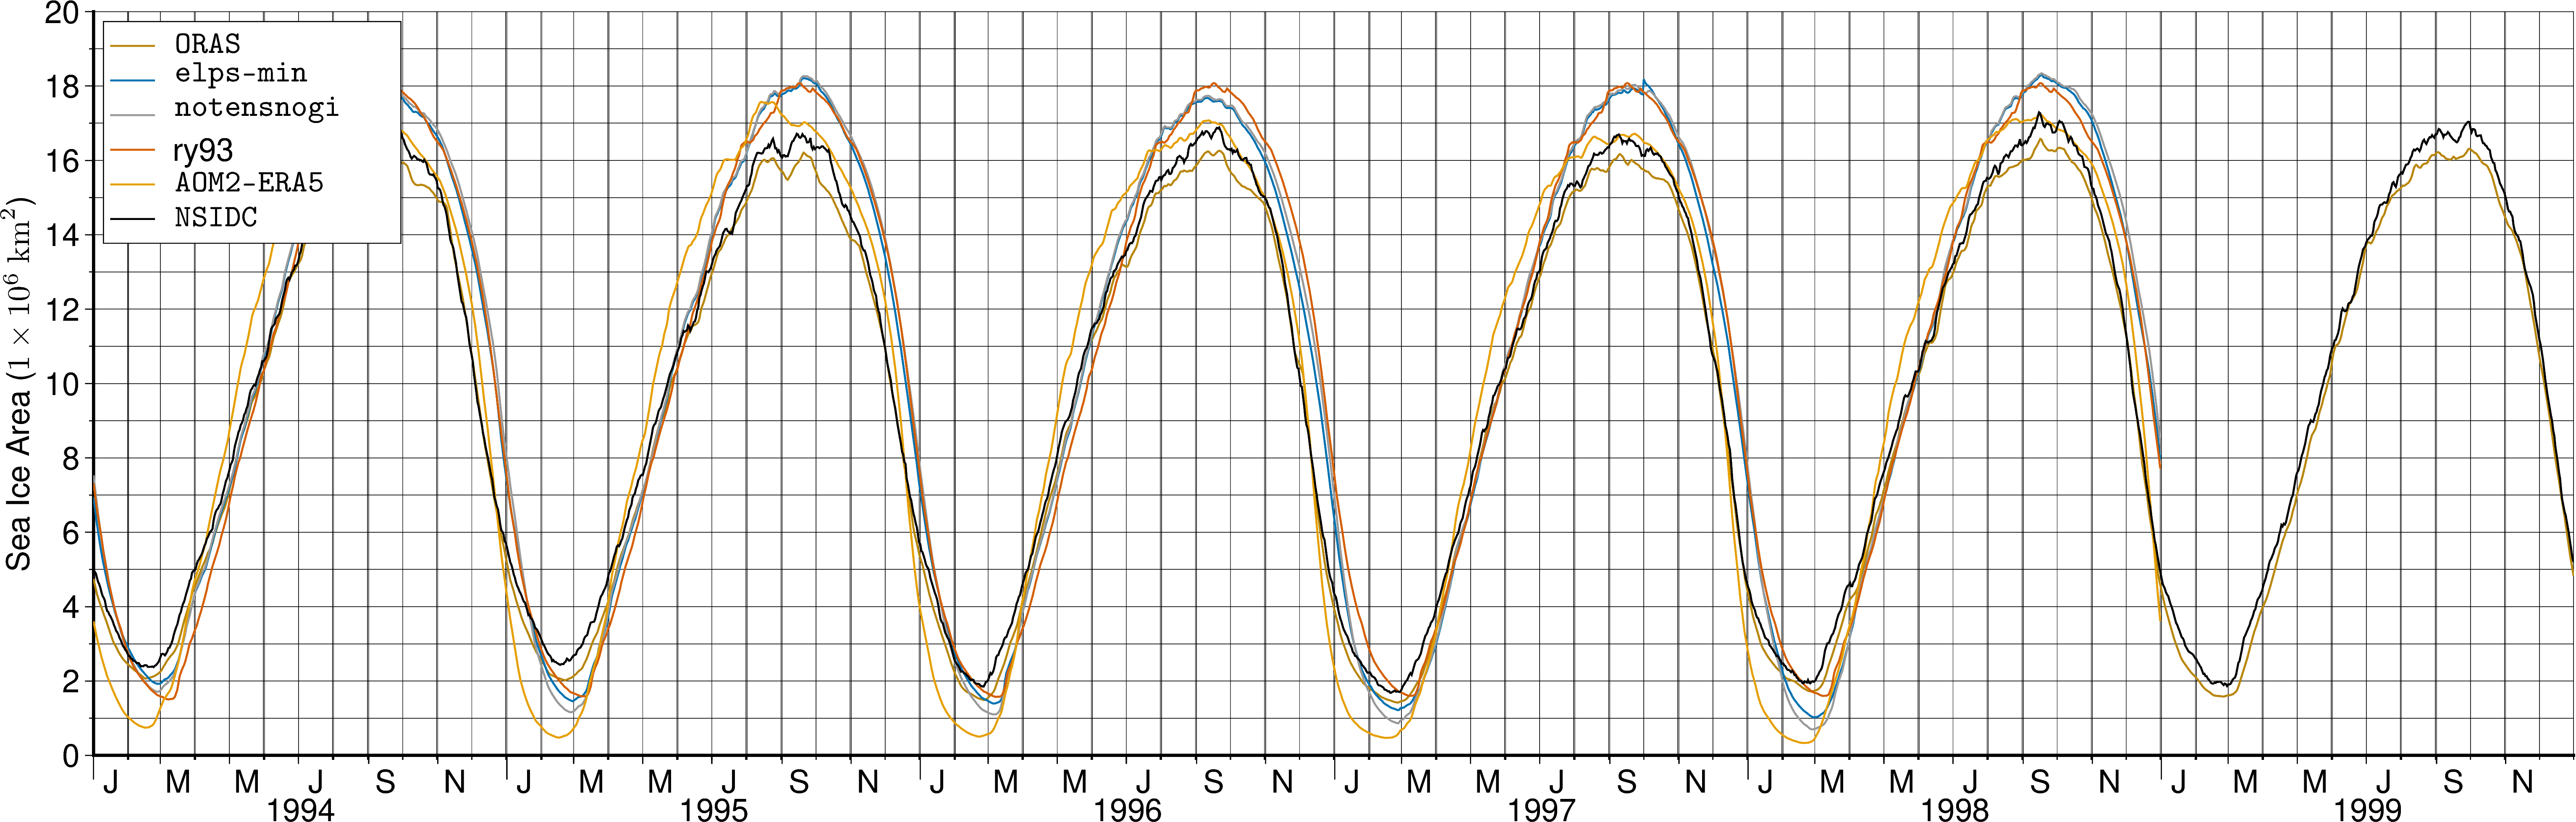

In [24]:
SI_tools = SI_tool_mgr.get_toolbox(sim_name=sim_name, dt0_str=dt0_str, dtN_str=dtN_str)
SI_tools.pygmt_timeseries(SIA_dict, 
                          comp_name   = "SH",
                          primary_key = "SIA",
                          climatology = False,
                          ylabel      = "Sea Ice Area (@[1\\times10^6\\ \\mathrm{km}^2@[)",
                          ylim        = [0,20],
                          ytick_pri   = 2,
                          ytick_sec   = 1,
                          show_fig    = True, 
                          legend_pos  = "JTL+jTL+o0.2c+w6c")

2025-08-26 09:23:35,196 - INFO - ORAS simulation will be included in extract_min_max_dates()
2025-08-26 09:23:35,205 - INFO - elps-min simulation will be included in extract_min_max_dates()
2025-08-26 09:23:35,209 - INFO - notensnogi simulation will be included in extract_min_max_dates()
2025-08-26 09:23:35,212 - INFO - ry93 simulation will be included in extract_min_max_dates()
2025-08-26 09:23:35,214 - INFO - AOM2-ERA5 simulation will be included in extract_min_max_dates()
2025-08-26 09:23:35,546 - INFO - pulling out data array for ORAS and putting into dataframe
2025-08-26 09:23:35,547 - INFO - legend label: @[\mathrm{ORAS}@[
2025-08-26 09:23:35,548 - INFO - line color  : #B8860B
2025-08-26 09:23:35,623 - INFO - pulling out data array for elps-min and putting into dataframe
2025-08-26 09:23:35,624 - INFO - legend label: @[\texttt{elps-min}@[
2025-08-26 09:23:35,626 - INFO - line color  : #0072B2
2025-08-26 09:23:43,620 - INFO - pulling out data array for notensnogi and putting into 

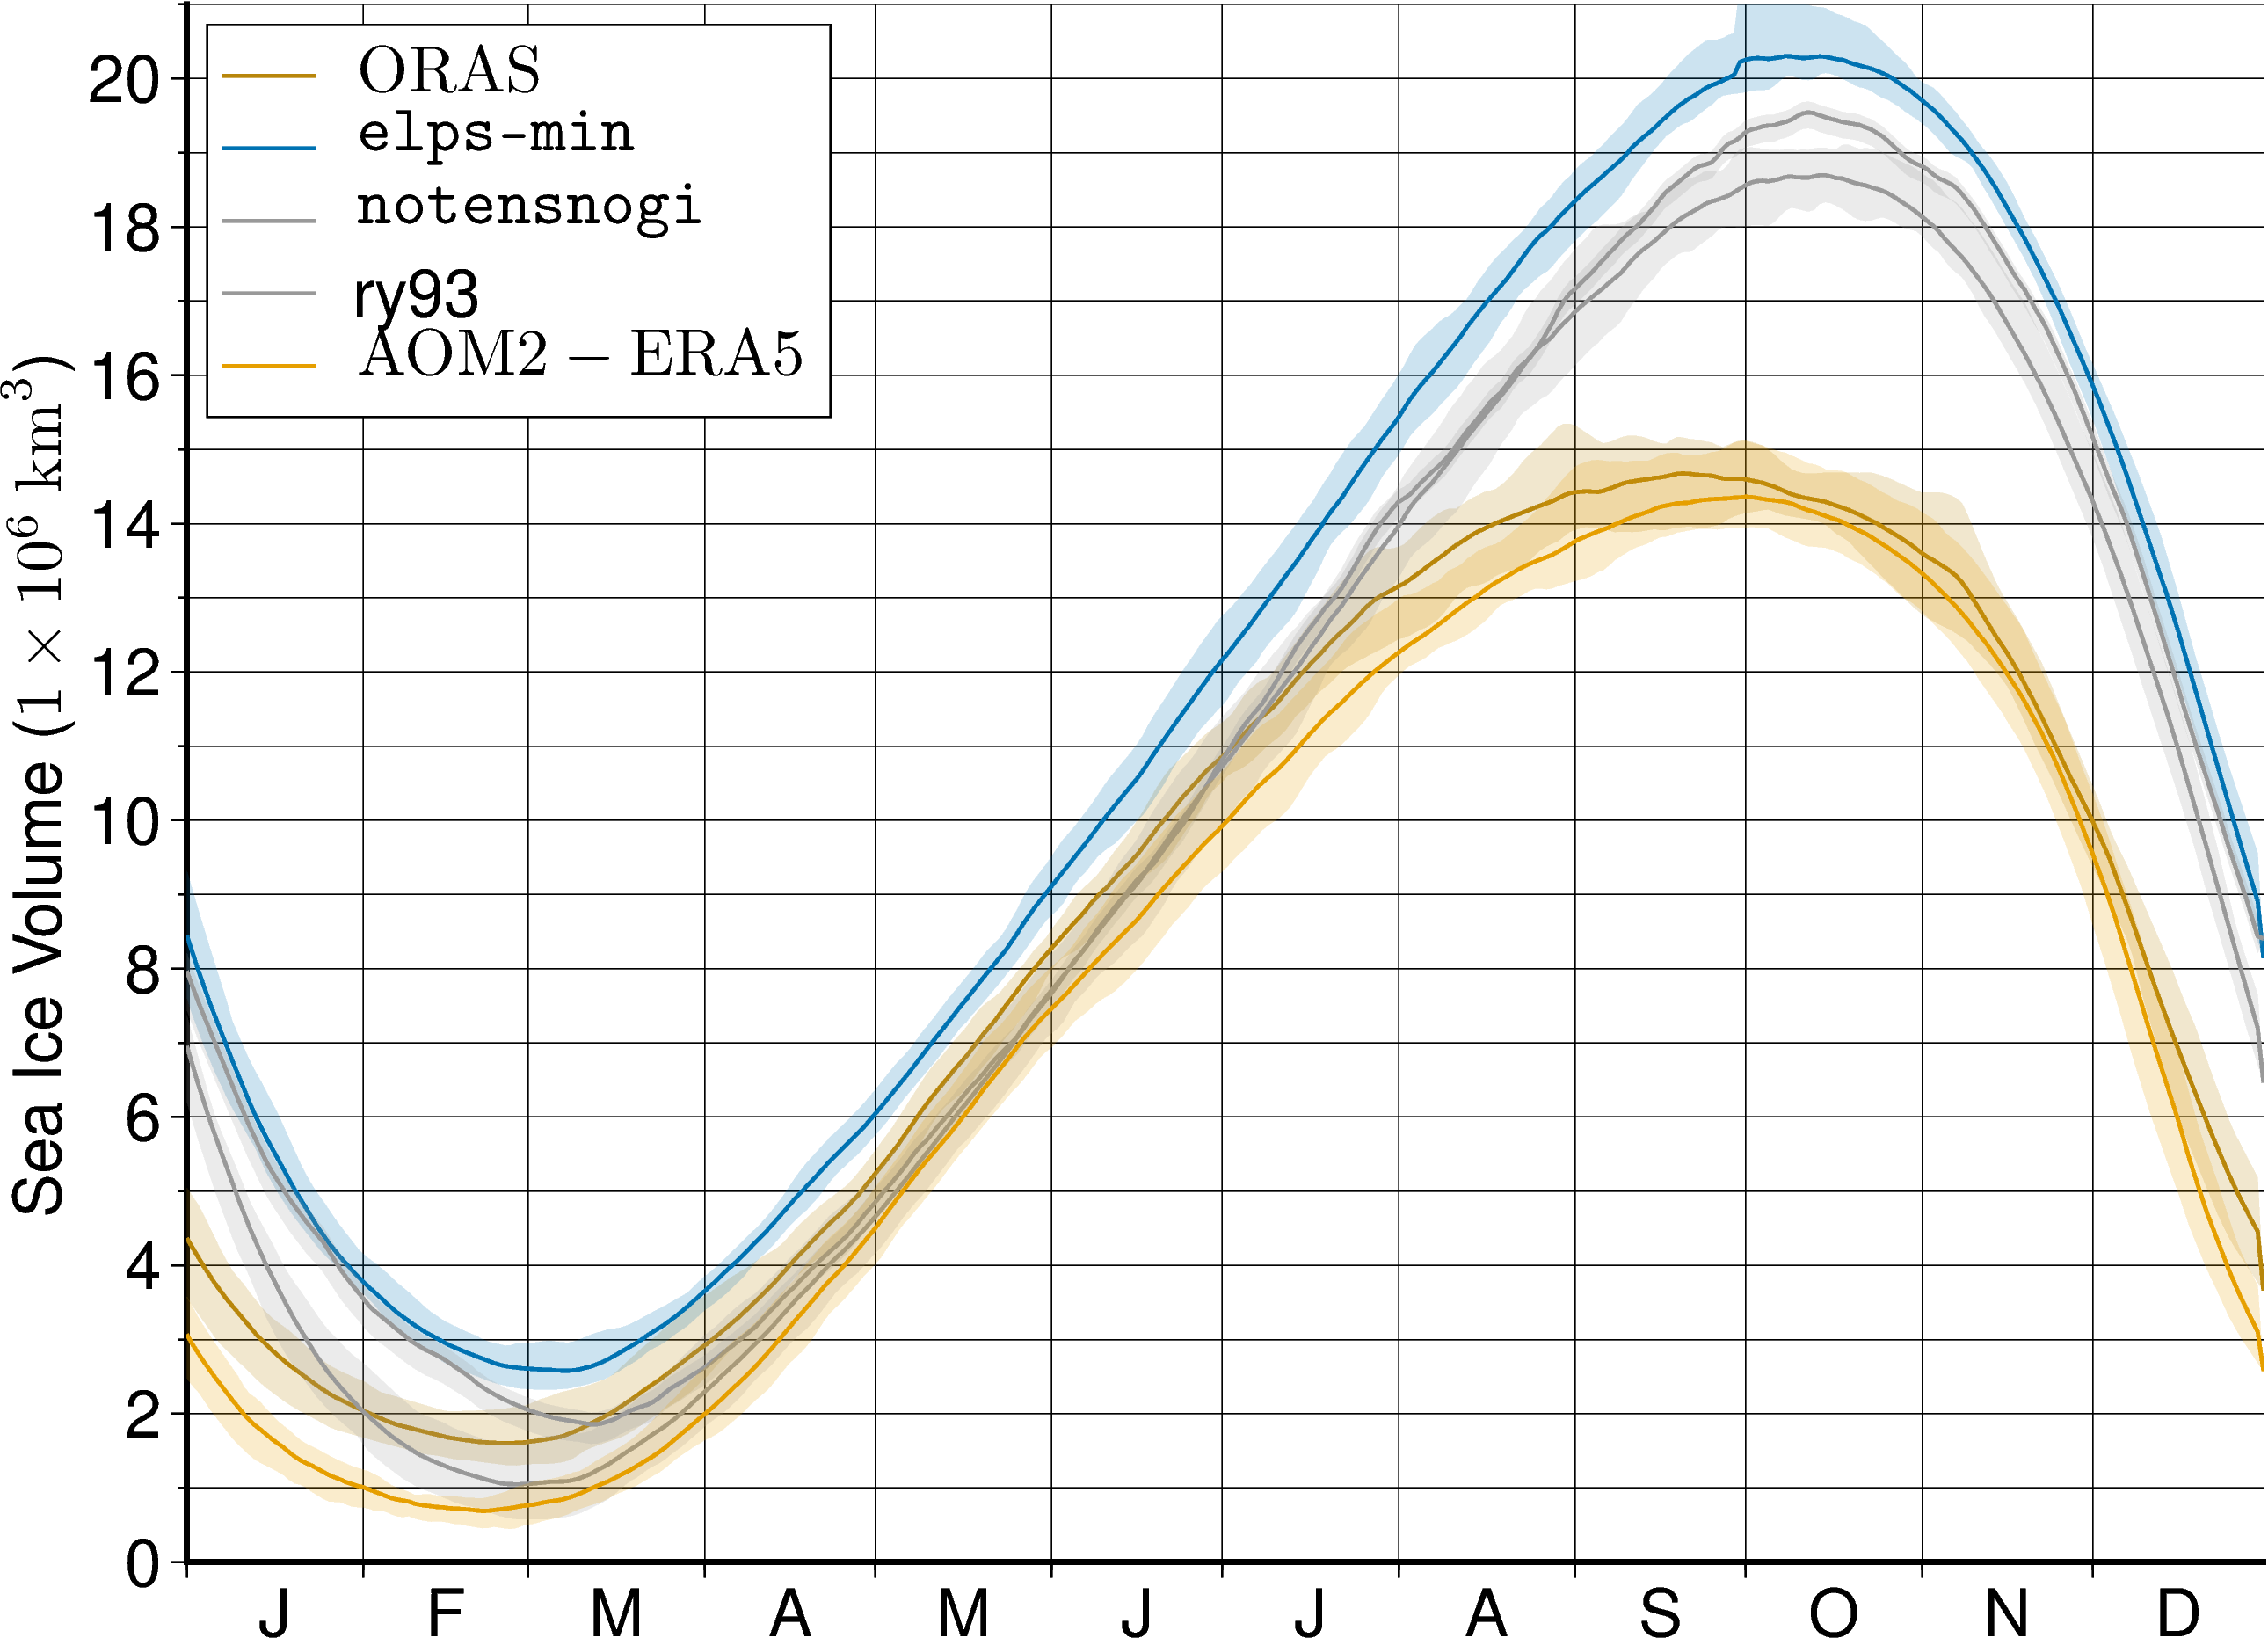

In [12]:
SI_tools.pygmt_timeseries(SIV_dict, 
                          comp_name   = "SH",
                          primary_key = "SIV",
                          climatology = True,
                          ylabel      = "Sea Ice Volume (@[1\\times10^6\\ \\mathrm{km}^3@[)",
                          ylim        = [0,21],
                          ytick_pri   = 2,
                          ytick_sec   = 1,
                          show_fig    = True, 
                          legend_pos  = "JTL+jTL+o0.2c+w6c")

In [ ]:
skip_names  = {"pack_ice.zarr","ice_diag_summary.csv","CMEMS-ORAS","AOM2-ERA5","AFIM_archive_status.json"}
for item in ["notensnogi"]:#Path(SI_tools.D_dict["AFIM_out"]).iterdir():
    # if item.name in skip_names:
    #     continue
    sim_name = item#.name
    SI_tools = SI_tool_mgr.get_toolbox(dt0_str  = dt0_str,
                                       dtN_str  = dtN_str,
                                       sim_name = sim_name)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIA",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 overwrite_fig     = True,
                                 show_fig          = True)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIT",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 overwrite_fig     = True,
                                 show_fig          = False)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIS",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 overwrite_fig     = True,
                                 show_fig          = False)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIMAR",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 water_clr         = "#F4A582",
                                 overwrite_fig     = True,
                                 show_fig          = False)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FIMVR",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 water_clr         = "#F4A582",
                                 overwrite_fig     = True,
                                 show_fig          = False)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FITAR",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 water_clr         = "#F4A582",
                                 overwrite_fig     = True,
                                 show_fig          = False)
    SI_tools.pygmt_fastice_panel(fast_ice_variable = "FITVR",   
                                 ice_class         = "FI_BT", 
                                 class_type        = "bin",   
                                 sim_name          = sim_name,
                                 font_annot_pri    = "26p,Times-Roman",
                                 font_lab          = "28p,Times-Bold",
                                 water_clr         = "#F4A582",
                                 overwrite_fig     = True,
                                 show_fig          = False)

In [ ]:
#AF2020 = xr.open_zarr(SI_tools.AF_FI_dict['P_AF2020_reG_zarr'], consolidated=False)
D_obs   = Path(SI_tools.AF_FI_dict['D_AF2020_db_org'])
P_orgs  = sorted(D_obs.glob("FastIce_70_*.nc"))
FI_obs  = xr.open_mfdataset(P_orgs, engine='netcdf4', combine='by_coords')
lat_c   = FI_obs['latitude'].isel(time=0)
lon_c   = FI_obs['longitude'].isel(time=0)
FI_mask = xr.where(FI_obs['Fast_Ice_Time_series'] >= 4, 1.0, 0.0)

In [ ]:
def print_scalar_vars(ds, label=""):
    """Print scalar variables and their values from an xarray.Dataset."""
    print(f"\nScalar variables in dataset {label}:\n" + "-"*40)
    for var in ds.data_vars:
        if ds[var].dims == ():
            val = ds[var].values.item()  # extract scalar value
            print(f"{var:30s}: {val:.4f}")
skip_names  = {"pack_ice.zarr","ice_diag_summary.csv","CMEMS-ORAS","AOM2-ERA5","AFIM_archive_status.json"}
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "FIA_and_FIP_figs.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools    = SI_tool_mgr.get_toolbox(sim_name = sim_name)
AF2020      = xr.open_dataset(SI_tools.AF_FI_dict['P_AF2020_FIA'])["AF2020"]
comp_name   = "Cstar-comparison"
comp_sims   = ["Cstar-min","Cstar-max","elps-min","gi-mid"]
sim_names   = ["Cstar-min","Cstar-max","Pstar-min","Pstar-max","elps-max","elps-mid","elps-min","elps-ext",
               "gi-max","gi-mid","gi-min","gi-nil","gi-nil-def","notensnogi","ktens-nil","ktens-min","ktens-max","ktens-ext"]
FIA_dict    = {'AF2020'     : {'FIA' : AF2020}}
FIT_dict    = {}
FIS_dict    = {}
FIMAR_dict  = {}
FIMVR_dict  = {}
FITAR_dict  = {}
FITVR_dict  = {}
for sim_name in comp_sims:
    FI_bn_mets = xr.open_zarr(Path('/','g','data','gv90','da1339','afim_output',sim_name,'zarr','ispd_thresh_5.0e-4',"FI_BT_bin_mets.zarr"))
    FIA_dict[sim_name]   = {'FIA'   : FI_bn_mets['FIA']}
    FIT_dict[sim_name]   = {'FIT'   : FI_bn_mets['FIT']}
    FIS_dict[sim_name]   = {'FIS'   : FI_bn_mets['FIS']}
    FIMAR_dict[sim_name] = {'FIMAR' : FI_bn_mets['FIMAR']}
    FIMVR_dict[sim_name] = {'FIMVR' : FI_bn_mets['FIMVR']}
    FITAR_dict[sim_name] = {'FITAR' : FI_bn_mets['FITAR']}
    FITVR_dict[sim_name] = {'FITVR' : FI_bn_mets['FITVR']}

In [ ]:
SI_tools.pygmt_timeseries(FIA_dict, 
                          comp_name   = f"{sim_name}-class",
                          primary_key = "FIA",
                          climatology = True,
                          ylabel      = "Fast Ice Area (@[1\\times10^3\\ \\mathrm{km}^2@[)",
                          show_fig    = True, 
                          legend_pos  = "JTL+jTL+o0.2c+w8c")
SI_tools.pygmt_timeseries(FIT_dict, 
                          comp_name   = f"{sim_name}-class",
                          primary_key = "FIT",
                          climatology = True,
                          ylabel      = "Fast Ice Thickness (m)",
                          ylim        = [1,7],
                          ytick_pri   = 1,
                          ytick_sec   = .5,
                          show_fig    = True, 
                          legend_pos  = "JTR+jTR+o0.2c+w8c")
SI_tools.pygmt_timeseries(FIS_dict, 
                          comp_name   = comp_name,
                          primary_key = "FIS",
                          climatology = True,
                          ylabel      = "Fast Ice Strength (mPa)",
                          ylim        = [0,1500],
                          ytick_pri   = 100,
                          ytick_sec   = 50,
                          show_fig    = True, 
                          legend_pos  = "JTR+jTR+o0.2c+w8c")
SI_tools.pygmt_timeseries(FIMAR_dict, 
                          comp_name   = comp_name,
                          primary_key = "FIMAR",
                          climatology = True,
                          ylabel      = "Fast Ice Mechanical Area Rate (m/s)",
                          ylim        = [-1.5,0.5],
                          ytick_pri   = .25,
                          ytick_sec   = .1,
                          show_fig    = True, 
                          legend_pos  = "JTR+jTR+o0.2c+w8c")
SI_tools.pygmt_timeseries(FIMVR_dict, 
                          comp_name   = comp_name,
                          primary_key = "FIMVR",
                          climatology = True,
                          ylabel      = "Fast Ice Mechanical Volume Rate (m/s)",
                          ylim        = [-1.5,0.5],
                          ytick_pri   = .25,
                          ytick_sec   = .1,
                          show_fig    = True, 
                          legend_pos  = "JBR+jBR+o0.2c+w8c")
SI_tools.pygmt_timeseries(FITAR_dict, 
                          comp_name   = comp_name,
                          primary_key = "FITAR",
                          climatology = True,
                          ylabel      = "Fast Ice Thermodynamic Area Rate (m/s)",
                          ylim        = [-0.5,1.5],
                          ytick_pri   = .25,
                          ytick_sec   = .1,
                          show_fig    = True, 
                          legend_pos  = "JBR+jBR+o0.2c+w8c")
SI_tools.pygmt_timeseries(FITVR_dict, 
                          comp_name   = comp_name,
                          
                          primary_key = "FITVR",
                          climatology = True,
                          ylabel      = "Fast Ice Thermodynamic Volume Rate (m/s)",
                          ylim        = [-3.5,3.5],
                          ytick_pri   = .5,
                          ytick_sec   = .25,
                          show_fig    = True, 
                          legend_pos  = "JBR+jBR+o0.2c+w8c")

In [ ]:
def plot_taylor_diagram(ds,
                        sims_include=None,
                        top_k=None,
                        var_prefix='SIA',
                        normalize=True,
                        add_rmsd_contours=True):
    sim_names = ds.simulation.values
    corr  = ds[f'{var_prefix}_skills_Corr'].values
    std_m = ds[f'{var_prefix}_skills_SD_Model'].values
    std_o = ds[f'{var_prefix}_skills_SD_Obs'].values
    rmsd  = ds[f'{var_prefix}_skills_RMSE'].values

    # Optional filtering: by name
    if sims_include is not None:
        mask = np.isin(sim_names, sims_include)
        sim_names = sim_names[mask]
        corr = corr[mask]
        std_m = std_m[mask]
        std_o = std_o[mask]
        rmsd = rmsd[mask]

    # Optional filtering: by top_k
    elif top_k is not None:
        sort_idx = np.argsort(rmsd)
        sim_names = sim_names[sort_idx][:top_k]
        corr = corr[sort_idx][:top_k]
        std_m = std_m[sort_idx][:top_k]
        std_o = std_o[sort_idx][:top_k]
        rmsd = rmsd[sort_idx][:top_k]

    # Normalize standard deviations
    if normalize:
        std_m_norm = std_m / std_o
        std_o_norm = np.ones_like(std_o)
    else:
        std_m_norm = std_m
        std_o_norm = std_o
    
    # Compute angle (theta) from correlation
    theta = np.arccos(corr)

    # Compute centered RMSD (optional but nice to verify)
    rmsd_c = np.sqrt(std_m_norm**2 + std_o_norm**2 - 2 * std_m_norm * std_o_norm * corr)

    # Start plotting
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, polar=True)

    # Plot reference point
    ax.plot(0, 1.0, 'ko', label='Obs (normalized)' if normalize else 'Obs')

    # Plot simulations
    for i, name in enumerate(sim_names):
        ax.plot(theta[i], std_m_norm[i], 'o', label=str(name))

    # Optional: Add RMSD contours
    if add_rmsd_contours:
        rs, ts = np.meshgrid(np.linspace(0, max(std_m_norm)*1.2, 300), np.linspace(0, np.pi/2, 300))
        corr_grid = np.cos(ts)
        rmsd_grid = np.sqrt(1 + rs**2 - 2 * rs * corr_grid)
        cs = ax.contour(ts, rs, rmsd_grid, levels=np.arange(0.2, 2.5, 0.2),
                        colors='gray', linewidths=0.5, linestyles='dotted')
        ax.clabel(cs, inline=1, fontsize=8, fmt="%.1f")
    # sc = ax.scatter(theta, std_m_norm, c=rmsd_c, cmap='viridis', s=80)
    # cbar = plt.colorbar(sc, ax=ax, pad=0.1)
    # cbar.set_label('Centered RMSD')
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('E')
    corr_levels = [0.90, 0.92, 0.94, 0.96, 0.98, 0.99, 1.0]
    ax.set_thetagrids(np.degrees(np.arccos(corr_levels)), labels=[f"{c:.2f}" for c in corr_levels])
    # ax.set_thetagrids(np.degrees(np.arccos(np.linspace(0.1, 1.0, 10))), 
    #                   labels=[f"{r:.2f}" for r in np.linspace(0.9, 0.0, 10)])
    ax.set_title(f"Taylor Diagram: {var_prefix} Skill", fontsize=14)
    ax.set_rlabel_position(135)
    ax.set_rlim(0, max(std_m_norm)*1.1)
    ax.set_thetamin(0)     # keep full angular range (or restrict more tightly)
    ax.set_thetamax(30)    # zoom into the high-correlation area
    ax.legend(loc='lower left')#, bbox_to_anchor=(1.4, 1.15))
    plt.tight_layout()
    plt.show()

In [ ]:
plot_taylor_diagram(ds, sims_include=["CMEMS-ORAS","AOM2-ERA5","ndte-min","ndte-max","elps-min","gi-nil-def"], var_prefix='SIA')

In [ ]:
def plot_skill_bar(ds, metric='SIA_skills_RMSE', title='RMSE (SIA)', sort=True):
    vals = ds[metric].values
    names = ds.simulation.values

    if sort:
        idx = np.argsort(vals)
        vals = vals[idx]
        names = names[idx]

    plt.figure(figsize=(10, 5))
    plt.bar(names, vals)
    plt.ylabel(title)
    plt.xticks(rotation=90)
    plt.title(f"{title} by Simulation")
    plt.tight_layout()
    plt.show()
plot_skill_bar(ds, metric='SIA_skills_RMSE', title='SIA RMSE')
plot_skill_bar(ds, metric='SIA_skills_Corr', title='SIA Correlation')

In [ ]:
def plot_all_seasonal_stats(ds):
    # Filter variables that match seasonal SIA or SIV stats
    seasonal_vars = [v for v in ds.data_vars if re.match(r'(SIA|SIV)_season_.*_(Mean|Std)$', v)]
    
    # Group by base metric (remove trailing _Mean or _Std)
    metric_groups = {}
    for var in seasonal_vars:
        base = re.sub(r'_(Mean|Std)$', '', var)
        if base not in metric_groups:
            metric_groups[base] = {}
        if var.endswith('Mean'):
            metric_groups[base]['mean'] = var
        elif var.endswith('Std'):
            metric_groups[base]['std'] = var

    sim_names = ds.simulation.values

    for base, pair in metric_groups.items():
        mean_vals = ds[pair['mean']].values
        std_vals = ds[pair['std']].values if 'std' in pair else None

        # Sort simulations by mean value
        idx = np.argsort(mean_vals)
        mean_sorted = mean_vals[idx]
        names_sorted = sim_names[idx]
        if std_vals is not None:
            std_sorted = std_vals[idx]
        
        # Plot
        plt.figure(figsize=(10, 5))
        if std_vals is not None:
            plt.errorbar(np.arange(len(names_sorted)), mean_sorted, yerr=std_sorted, fmt='o-', capsize=3)
        else:
            plt.plot(np.arange(len(names_sorted)), mean_sorted, 'o-')

        plt.xticks(np.arange(len(names_sorted)), names_sorted, rotation=90)
        plt.title(base.replace("_", " "))
        plt.tight_layout()
        plt.show()
        

In [ ]:
plot_all_seasonal_stats(ds)

In [8]:
from scipy.stats import binned_statistic_2d
from tqdm import tqdm

def sit_for_year(sim_name: str, yr: int):
    dt0, dtN = f"{yr}-01-01", f"{yr}-12-31"
    SI_tools = SI_tool_mgr.get_toolbox(sim_name=sim_name, dt0_str=dt0, dtN_str=dtN)
    so = SI_tools.load_cice_zarr(slice_hem=True, variables=["aice","hi","tarea"])
    sic = so["aice"]                          # [time, j, i]
    hi  = so["hi"]                            # [time, j, i]
    A   = so["tarea"].isel(time=0).drop_vars("time", errors="ignore")  # [j, i]
    sit = SI_tools.compute_hemisphere_ice_thickness(sic, hi, A)
    sit = sit.rename("SIT")
    return sit

for sim_name in ["elps-min","notensnogi","ry93","AOM2-ERA5"]:
    sits = []
    for yr in range(1994, 2000):
        sit = sit_for_year(sim_name, yr)
        sits.append(sit)
    SIT = xr.concat(sits, dim="time").sortby("time")
    ds = xr.Dataset({"SIT": SIT})
    SIT_dict[sim_name] = {"SIT": ds["SIT"]} 

2025-08-29 11:36:06,355 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox.log
2025-08-29 11:36:06,382 - INFO - Dask Client Connected
  Dashboard      : /proxy/8787/status
  Threads        : 5
  Threads/Worker : [1, 1, 1, 1, 1]
  Total Memory   : 35.00 GB

2025-08-29 11:36:06,383 - INFO - hemisphere initialised: SH
2025-08-29 11:36:06,385 - INFO - reading /g/data/gv90/da1339/afim_output/elps-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/elps-min/ice_in_AFIM_subset_elps-min.json
2025-08-29 11:36:06,387 - INFO -  self.ice_class defined as FI_BT
2025-08-29 11:36:06,389 - INFO - --- SeaIceToolbox Summary ---
2025-08-29 11:36:06,390 - INFO - Simulation Name     : elps-min
2025-08-29 11:36:06,391 - INFO - Analysis Start Date : 1994-01-01
2025-08-29 11:36:06,392 - INFO - Analysis End Date   : 1994-12-31
2025-08-29 11:36:06,394 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-08-29 11:36:06,394 - INFO - Speed Type(s)       : BT
2025-08-29 11:36:06,396 - INFO - Ice T

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
ESA-CCI Envisat SH L2P SIT → Daily time series (2002–2012) + DOY climatology

Outputs one NetCDF with:
  time-series:
    - SIT                        [m]  daily spatial mean along-track
    - SIT_uncertainty_daily_SE   [m]  propagated SE of daily spatial mean
    - SIT_uncertainty_daily_mean [m]  simple mean of reported uncertainties
    - n_samples_daily            [-]  daily valid-sample count
  climatology (per DOY mapped onto a reference year):
    - sit_climatology                   [m]
    - sit_climatology_std               [m]
    - n_days_contributing               [-]
    - sit_uncertainty_daily_mean_clim   [m]
    - sit_uncertainty_daily_mean_std    [m]
    - sit_uncertainty_climatology       [m]
"""

import os
import re
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

# ----------------------------
# User paths / settings
# ----------------------------
ESA_CCI_DIR = os.path.expanduser("~/seaice/ESA_CCI/L2P/envisat/sh")
FILE_GLOB   = "ESACCI-SEAICE-L2P-SITHICK-RA2_ENVISAT-SH-*.nc"

OUT_DIR  = os.path.expanduser("~/AFIM_archive/ESA_CCI")
OUT_FILE = "SIT_ESA-CCI_daily_and_climatology_2002-2012.nc"

YEAR_MIN, YEAR_MAX = 2002, 2012

# Climatology handling
DROP_LEAP_DAY = True  # if True → 365-day DOY climatology; if False → keep 366

# Basic QC / filters
MIN_VALID_M = 0.0
MAX_VALID_M = 20.0
LAT_MAX_DEG = -50.0   # only south of 50S; set to None to disable

# ----------------------------
# Helpers
# ----------------------------
def infer_year_from_fname(fp: str) -> int | None:
    """Extract YYYY from ...-YYYYMMDD-... pattern in filename."""
    base = os.path.basename(fp)
    m = re.search(r"(\d{4})\d{4}", base)  # YYYYMMDD
    return int(m.group(1)) if m else None

def daily_spatial_means_from_file(fp: str) -> xr.Dataset:
    """
    From one ESA-CCI L2P file, compute daily spatial aggregates:
      - sit_daily: daily spatial mean SIT
      - se_daily:  propagated SE of the daily spatial mean (sqrt(mean(u^2)/n))
      - u_simple_daily: simple mean of reported uncertainties (diagnostic)
      - n_daily: valid-sample count
    Returns Dataset with coord 'date' (UTC midnight).
    """
    with xr.open_dataset(fp, decode_times=True) as ds:
        sit = ds.get("sea_ice_thickness")
        u   = ds.get("sea_ice_thickness_uncertainty")
        if sit is None or u is None:
            raise ValueError("Missing required variables 'sea_ice_thickness' and/or 'sea_ice_thickness_uncertainty'")

        # Geographic filter (SH file, but tighten to south of LAT_MAX_DEG if requested)
        if LAT_MAX_DEG is not None and "lat" in ds:
            mask_lat = ds["lat"] <= LAT_MAX_DEG
            sit = sit.where(mask_lat)
            u   = u.where(mask_lat)

        # SIT QC and align masks
        sit = sit.where((sit >= MIN_VALID_M) & (sit <= MAX_VALID_M))
        u   = u.where(sit.notnull())

        # Group by UTC day
        dates = sit["time"].dt.floor("D").rename("date")

        # Daily aggregates
        sit_daily = sit.groupby(dates).mean("time", skipna=True).rename("sit_daily")
        u_simple_daily = u.groupby(dates).mean("time", skipna=True).rename("u_simple_daily")
        n_daily = sit.groupby(dates).count("time").rename("n_daily").astype("int32")

        # Propagated SE of the daily spatial mean: sqrt(mean(u^2)/n)
        u2_mean = (u ** 2).groupby(dates).mean("time", skipna=True)
        # Avoid divide-by-zero
        se_daily = xr.apply_ufunc(
            np.sqrt,
            xr.where(n_daily > 0, u2_mean / n_daily, np.nan),
            dask="allowed",
        ).rename("se_daily")

    out = xr.Dataset(
        data_vars=dict(
            sit_daily=sit_daily,
            u_simple_daily=u_simple_daily,
            se_daily=se_daily,
            n_daily=n_daily,
        )
    ).sortby("date")
    return out

# ----------------------------
# Main
# ----------------------------
def main():
    Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

    files = sorted(glob.glob(os.path.join(ESA_CCI_DIR, FILE_GLOB)))
    files = [fp for fp in files if (infer_year_from_fname(fp) is not None
                                    and YEAR_MIN <= infer_year_from_fname(fp) <= YEAR_MAX)]
    if not files:
        raise SystemExit("No ESA-CCI files found for the requested year range.")

    # Per-file processing → daily datasets
    daily_dsets = []
    for fp in files:
        print("processing", fp, flush=True)
        try:
            dsd = daily_spatial_means_from_file(fp)
            daily_dsets.append(dsd)
        except Exception as e:
            print(f"[WARN] Skipping {fp}: {e}", flush=True)

    if not daily_dsets:
        raise SystemExit("No daily data produced (all files failed or were empty).")

    # Concat on 'date' → (date) Dataset with vars: sit_daily, se_daily, u_simple_daily, n_daily
    daily_all: xr.Dataset = xr.concat(daily_dsets, dim="date").sortby("date")
    # If duplicates for a date exist, average them
    daily_all = daily_all.groupby("date").mean("date", skipna=True)
    # --- Rename coord dim once so everything is on 'time' ---
    daily_all = daily_all.rename({"date": "time"}).sortby("time")
    # Daily time series (already 1D on 'time'; no need to rebuild a coord)
    SIT_ts = daily_all["sit_daily"].rename("SIT").assign_attrs(
        long_name="daily spatial mean sea-ice thickness",
        standard_name="sea_ice_thickness",
        units="m",
    )
    SE_ts = daily_all["se_daily"].rename("SIT_uncertainty_daily_SE").assign_attrs(
        long_name="propagated standard error of the daily spatial mean (sqrt(mean(u^2)/n))",
        units="m",
    )
    Umean_ts = daily_all["u_simple_daily"].rename("SIT_uncertainty_daily_mean").assign_attrs(
        long_name="simple mean of reported per-sample uncertainties (diagnostic)",
        units="m",
    )
    N_ts = daily_all["n_daily"].astype("int32").rename("n_samples_daily").assign_attrs(
        long_name="daily valid-sample count",
    )

    # SIT_ts = xr.DataArray(
    #     daily_all["sit_daily"].values,
    #     dims=["time"], coords={"time": time},
    #     name="SIT",
    #     attrs=dict(
    #         long_name="daily spatial mean sea-ice thickness",
    #         standard_name="sea_ice_thickness",
    #         units="m",
    #     ),
    # )
    # SE_ts = xr.DataArray(
    #     daily_all["se_daily"].values,
    #     dims=["time"], coords={"time": time},
    #     name="SIT_uncertainty_daily_SE",
    #     attrs=dict(
    #         long_name="propagated standard error of the daily spatial mean (sqrt(mean(u^2)/n))",
    #         units="m",
    #     ),
    # )
    # Umean_ts = xr.DataArray(
    #     daily_all["u_simple_daily"].values,
    #     dims=["time"], coords={"time": time},
    #     name="SIT_uncertainty_daily_mean",
    #     attrs=dict(
    #         long_name="simple mean of reported per-sample uncertainties (diagnostic)",
    #         units="m",
    #     ),
    # )
    # N_ts = xr.DataArray(
    #     daily_all["n_daily"].values.astype("int32"),
    #     dims=["time"], coords={"time": time},
    #     name="n_samples_daily",
    #     attrs=dict(long_name="daily valid-sample count"),
    # )
    
    # ----------------------------
    # Daily climatology by DOY
    # ----------------------------
    daily_for_clim = daily_all
    if DROP_LEAP_DAY:
        is_feb29 = (daily_for_clim["time"].dt.month == 2) & (daily_for_clim["time"].dt.day == 29)
        daily_for_clim = daily_for_clim.where(~is_feb29, drop=True)
    
    doy = daily_for_clim["time"].dt.dayofyear.rename("doy")
    g   = daily_for_clim.groupby(doy)
    
    # SIT climatology
    sit_doy_mean = g["sit_daily"].mean("time", skipna=True)
    sit_doy_std  = g["sit_daily"].std("time",  skipna=True)
    sit_doy_cnt  = g["sit_daily"].count("time").astype("int32")
    
    # Uncertainty climatology pieces
    se_daily_mean = g["se_daily"].mean("time", skipna=True)
    se_daily_std  = g["se_daily"].std("time",  skipna=True)
    # SE_clim = sqrt( mean(SE_daily^2) / N_years )
    se2_daily_mean = g["se_daily"].map(lambda x: (x ** 2).mean("time", skipna=True))
    se_clim = xr.apply_ufunc(
        np.sqrt,
        xr.where(sit_doy_cnt > 0, se2_daily_mean / sit_doy_cnt, np.nan),
        dask="allowed",
    )
    # daily_for_clim = daily_all
    # if DROP_LEAP_DAY:
    #     is_feb29 = (daily_for_clim["date"].dt.month == 2) & (daily_for_clim["date"].dt.day == 29)
    #     daily_for_clim = daily_for_clim.where(~is_feb29, drop=True)

    # doy = daily_for_clim["date"].dt.dayofyear.rename("doy")
    # g   = daily_for_clim.groupby(doy)

    # # SIT climatology
    # sit_doy_mean = g["sit_daily"].mean("date", skipna=True)
    # sit_doy_std  = g["sit_daily"].std("date",  skipna=True)
    # sit_doy_cnt  = g["sit_daily"].count("date").astype("int32")

    # # Uncertainty climatology pieces
    # se_daily_mean = g["se_daily"].mean("date", skipna=True)
    # se_daily_std  = g["se_daily"].std("date",  skipna=True)
    # # SE_clim = sqrt( mean(SE_daily^2) / N_years )
    # se2_daily_mean = g["se_daily"].map(lambda x: (x ** 2).mean("date", skipna=True))
    # se_clim = xr.apply_ufunc(
    #     np.sqrt,
    #     xr.where(sit_doy_cnt > 0, se2_daily_mean / sit_doy_cnt, np.nan),
    #     dask="allowed",
    # )

    # Build reference-year time template (365 if no leap, else 366)
    n_doy = int(sit_doy_mean.sizes["doy"])
    template_year = 2001 if n_doy == 365 else 2000  # 2000 is leap
    clim_time = xr.DataArray(
        pd.date_range(f"{template_year}-01-01", f"{template_year}-12-31", freq="D"),
        dims="clim_time",
        name="clim_time",
    )

    def to_clim(a: xr.DataArray, name: str) -> xr.DataArray:
        return xr.DataArray(
            a.sortby("doy").values,
            dims=["clim_time"],
            coords={"clim_time": clim_time},
            name=name,
        )

    sit_mean   = to_clim(sit_doy_mean, "sit_climatology").assign_attrs(
        long_name="sea ice thickness daily climatology",
        standard_name="sea_ice_thickness",
        units="m",
    )
    sit_std    = to_clim(sit_doy_std, "sit_climatology_std").assign_attrs(
        long_name="std across years (per DOY)", units="m"
    )
    sit_count  = to_clim(sit_doy_cnt, "n_days_contributing").astype("int32")

    u_daily    = to_clim(se_daily_mean, "sit_uncertainty_daily_mean").assign_attrs(
        long_name="mean propagated SE of daily spatial mean (per DOY)", units="m"
    )
    u_daily_sd = to_clim(se_daily_std, "sit_uncertainty_daily_mean_std").assign_attrs(
        long_name="std across years of SE_daily (per DOY)", units="m"
    )
    u_clim     = to_clim(se_clim, "sit_uncertainty_climatology").assign_attrs(
        long_name="propagated SE of DOY climatological mean", units="m"
    )

    # ----------------------------
    # Assemble output dataset
    # ----------------------------
    ds_out = xr.Dataset(
        data_vars=dict(
            # Daily time series (2002–2012)
            SIT                        = SIT_ts,
            SIT_uncertainty_daily_SE   = SE_ts,
            SIT_uncertainty_daily_mean = Umean_ts,
            n_samples_daily            = N_ts,

            # DOY climatology (365 or 366)
            sit_climatology                  = sit_mean,
            sit_climatology_std              = sit_std,
            n_days_contributing              = sit_count,
            sit_uncertainty_daily_mean_clim  = u_daily,
            sit_uncertainty_daily_mean_std   = u_daily_sd,
            sit_uncertainty_climatology      = u_clim,
        ),
        coords=dict(
            time=SIT_ts["time"],
            clim_time=sit_mean["clim_time"],
        ),
        attrs=dict(
            title="ESA-CCI Envisat SH SIT: daily time series (2002–2012) + DOY climatology",
            summary=f"Spatial mean of ESA-CCI along-track SIT per UTC day; DOY climatology over {YEAR_MIN}–{YEAR_MAX}.",
            source="ESA CCI Sea Ice Thickness L2P (RA2/ENVISAT) Southern Hemisphere",
            processing=(
                "Per-file daily spatial mean → concat → (a) daily time series; (b) DOY climatology. "
                "Uncertainty treated as independent per-sample SE. "
                "Daily SE = sqrt(mean(u^2)/n); climatological SE = sqrt(mean(SE_daily^2)/N_years). "
            )
            + (f"lat ≤ {LAT_MAX_DEG}°, " if LAT_MAX_DEG is not None else "")
            + ("Feb 29 removed from climatology. " if DROP_LEAP_DAY else "Feb 29 retained in climatology."),
            conventions="CF-1.9 (approx)",
            institution="UTAS / CSIRO (processing), ESA CCI (data)",
        ),
    )

    # Encodings (compression + types)
    encoding = {
        "SIT":                        {"zlib": True, "complevel": 4, "_FillValue": np.float32(np.nan), "dtype": "float32"},
        "SIT_uncertainty_daily_SE":   {"zlib": True, "complevel": 4, "_FillValue": np.float32(np.nan), "dtype": "float32"},
        "SIT_uncertainty_daily_mean": {"zlib": True, "complevel": 4, "_FillValue": np.float32(np.nan), "dtype": "float32"},
        "n_samples_daily":            {"zlib": True, "complevel": 4, "dtype": "int32"},

        "sit_climatology":                  {"zlib": True, "complevel": 4, "_FillValue": np.float32(np.nan), "dtype": "float32"},
        "sit_climatology_std":              {"zlib": True, "complevel": 4, "_FillValue": np.float32(np.nan), "dtype": "float32"},
        "n_days_contributing":              {"zlib": True, "complevel": 4, "dtype": "int32"},
        "sit_uncertainty_daily_mean_clim":  {"zlib": True, "complevel": 4, "_FillValue": np.float32(np.nan), "dtype": "float32"},
        "sit_uncertainty_daily_mean_std":   {"zlib": True, "complevel": 4, "_FillValue": np.float32(np.nan), "dtype": "float32"},
        "sit_uncertainty_climatology":      {"zlib": True, "complevel": 4, "_FillValue": np.float32(np.nan), "dtype": "float32"},
        # coords
        "time":      {"units": "days since 2002-01-01", "calendar": "standard"},
        "clim_time": {"units": f"days since {template_year}-01-01", "calendar": "standard"},
    }

    out_path = os.path.join(OUT_DIR, OUT_FILE)
    ds_out.to_netcdf(out_path, encoding=encoding)
    print(f"Wrote: {out_path}")
    print(f"- daily series length: {SIT_ts.sizes['time']} days "
          f"({pd.to_datetime(str(SIT_ts['time'].values[0])):%Y-%m-%d} → "
          f"{pd.to_datetime(str(SIT_ts['time'].values[-1])):%Y-%m-%d})")
    print(f"- climatology DOYs: {n_doy} (template year {template_year})")

if __name__ == "__main__":
    main()


processing /home/581/da1339/seaice/ESA_CCI/L2P/envisat/sh/ESACCI-SEAICE-L2P-SITHICK-RA2_ENVISAT-SH-20021001-fv2.0.nc
processing /home/581/da1339/seaice/ESA_CCI/L2P/envisat/sh/ESACCI-SEAICE-L2P-SITHICK-RA2_ENVISAT-SH-20021002-fv2.0.nc
processing /home/581/da1339/seaice/ESA_CCI/L2P/envisat/sh/ESACCI-SEAICE-L2P-SITHICK-RA2_ENVISAT-SH-20021003-fv2.0.nc
processing /home/581/da1339/seaice/ESA_CCI/L2P/envisat/sh/ESACCI-SEAICE-L2P-SITHICK-RA2_ENVISAT-SH-20021004-fv2.0.nc
processing /home/581/da1339/seaice/ESA_CCI/L2P/envisat/sh/ESACCI-SEAICE-L2P-SITHICK-RA2_ENVISAT-SH-20021005-fv2.0.nc
processing /home/581/da1339/seaice/ESA_CCI/L2P/envisat/sh/ESACCI-SEAICE-L2P-SITHICK-RA2_ENVISAT-SH-20021006-fv2.0.nc
processing /home/581/da1339/seaice/ESA_CCI/L2P/envisat/sh/ESACCI-SEAICE-L2P-SITHICK-RA2_ENVISAT-SH-20021007-fv2.0.nc
processing /home/581/da1339/seaice/ESA_CCI/L2P/envisat/sh/ESACCI-SEAICE-L2P-SITHICK-RA2_ENVISAT-SH-20021008-fv2.0.nc
processing /home/581/da1339/seaice/ESA_CCI/L2P/envisat/sh/ESACCI

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Daily SIT (and uncertainties) from satellite mirrors, split by Institution×Level,
plus a combined series across all buckets.

Buckets emitted (when present):
  - ESA_L2P, ESA_L3C, AWI_L2P, AWI_L3C
  - ALL  (combined across present buckets, day-by-day)

Inputs (CLI):
  --start YYYY-MM-DD
  --end   YYYY-MM-DD
  --hem   sh|nh
  --root-esa  ~/seaice/ESA/CCI
  --root-awi  ~/seaice/AWI
  --levels    L2P,L3C,l2p_release,l3cp_release   (filter; default = all)
  --sensors   cryosat2,envisat,sentinel3a,sentinel3b   (optional filter)
  --versions  v2.0,v3.0                    (ESA only; optional filter)
  --lat-cut   -50.0                        (SH keep lat<=; NH keep lat>=; set NaN to disable)
  --out       SIT_daily_split.nc

Output variables are suffixed by the bucket key, e.g.:
  SIT_ESA_L2P, SIT_uncertainty_daily_SE_ESA_L2P, ..., n_samples_daily_ESA_L2P
and for the combined:
  SIT_ALL, SIT_uncertainty_daily_SE_ALL, SIT_uncertainty_daily_mean_ALL, n_samples_daily_ALL
"""

from __future__ import annotations
import os, re, sys, math, glob, argparse
from pathlib import Path, PurePosixPath
from typing import Optional, List, Tuple, Dict
import numpy as np
import pandas as pd
import xarray as xr

# ---------- defaults ----------
ROOT_ESA_DEF = os.path.expanduser("~/seaice/ESA/CCI")
ROOT_AWI_DEF = os.path.expanduser("~/seaice/AWI")
OPEN_KW = dict(decode_times=True, chunks={})

VALID_VAR_NAMES = {
    "sit": ["sea_ice_thickness","SIT","sit"],
    "unc": ["sea_ice_thickness_uncertainty","SIT_uncertainty","uncertainty","unc"],
    "lat": ["lat","latitude","LAT"],
}

def log(msg): print(msg, flush=True)

def cosdeg(x): return np.cos(np.deg2rad(x))

def is_l2p_path(p: Path) -> bool:
    s = str(p).lower()
    return ("/l2p/" in s) or ("/l2p_" in s) or ("/l2p-" in s) or ("/l2p_release/" in s)

def is_l3_path(p: Path) -> bool:
    s = str(p).lower()
    return ("l3c" in s) or ("l3cp" in s) or ("/l3c_release/" in s) or ("/l3cp_release/" in s)

def days_in_month(y,m):
    if m in (1,3,5,7,8,10,12): return 31
    if m in (4,6,9,11): return 30
    return 29 if ((y%4==0 and y%100!=0) or (y%400==0)) else 28

# ---------- discovery ----------
def find_first_var(ds: xr.Dataset, candidates: List[str]) -> Optional[str]:
    for k in candidates:
        if k in ds.variables: return k
    return None

def discover_esa(root: Path, hem: str, levels: List[str]|None, sensors: List[str]|None,
                 versions: List[str]|None, t0: pd.Timestamp, t1: pd.Timestamp) -> Dict[Tuple[str,str], List[Path]]:
    """
    ESA layout: root/L2P|L3C/sensor/v2.0|v3.0/NH|SH/YYYY/MM/*.nc
    Returns dict keyed by ('ESA','L2P' or 'L3C') → list(paths)
    """
    out: Dict[Tuple[str,str], List[Path]] = {("ESA","L2P"):[], ("ESA","L3C"):[]}
    lvls = set(l.upper() for l in levels) if levels else {"L2P","L3C"}
    sens = set(s.lower() for s in sensors) if sensors else None
    vers = set(v.lower() for v in versions) if versions else None
    H = hem.upper()

    for L in lvls:
        Ldir = root / L
        if not Ldir.exists(): continue
        for sdir in sorted(Ldir.iterdir()):
            sensor = sdir.name.lower()
            if sens and sensor not in sens: continue
            for vdir in sorted(sdir.iterdir()):
                version = vdir.name.lower()
                if versions and version not in vers: continue
                hdir = vdir / H
                if not hdir.exists(): continue
                for ydir in sorted(hdir.glob("[12][0-9][0-9][0-9]")):
                    y = int(ydir.name)
                    for mdir in sorted(ydir.glob("[01][0-9]")):
                        m = int(mdir.name)
                        first = pd.Timestamp(year=y,month=m,day=1,tz="UTC")
                        last  = pd.Timestamp(year=y,month=m,day=days_in_month(y,m),tz="UTC")
                        if last < t0 or first > t1: continue
                        out[("ESA",L)].extend(sorted(mdir.glob("*.nc")))
    return out

def discover_awi(root: Path, hem: str, levels: List[str]|None, sensors: List[str]|None,
                 t0: pd.Timestamp, t1: pd.Timestamp) -> Dict[Tuple[str,str], List[Path]]:
    """
    AWI layout (monthly): root/[l2p|l3cp]_release/[nh|sh]/sensor/YYYY/*.nc
    Map to levels: l2p_release→L2P, l3cp_release→L3C
    """
    out: Dict[Tuple[str,str], List[Path]] = {("AWI","L2P"):[], ("AWI","L3C"):[]}
    lvls = set(l.lower() for l in levels) if levels else {"l2p_release","l3cp_release"}
    sens = set(s.lower() for s in sensors) if sensors else None
    h = hem.lower()

    for Lraw in lvls:
        Lnorm = "L2P" if "l2p" in Lraw else "L3C"
        Ldir = root / Lraw / h
        if not Ldir.exists(): continue
        for sdir in sorted(Ldir.iterdir()):
            sensor = sdir.name.lower()
            if sens and sensor not in sens: continue
            for ydir in sorted(sdir.glob("[12][0-9][0-9][0-9]")):
                y = int(ydir.name)
                y0 = pd.Timestamp(year=y,month=1,day=1,tz="UTC")
                y1 = pd.Timestamp(year=y,month=12,day=31,tz="UTC")
                if y1 < t0 or y0 > t1: continue
                out[("AWI",Lnorm)].extend(sorted(ydir.glob("*.nc")))
    return out

# ---------- per-file aggregation ----------
def aggregate_l2p_daily(fp: Path, hem: str, lat_cut: Optional[float]) -> xr.Dataset:
    with xr.open_dataset(fp, **OPEN_KW) as ds:
        v_sit = find_first_var(ds, VALID_VAR_NAMES["sit"])
        v_unc = find_first_var(ds, VALID_VAR_NAMES["unc"])
        if not v_sit or not v_unc:
            raise ValueError(f"{fp.name}: missing SIT/uncertainty")
        sit, unc = ds[v_sit], ds[v_unc]
        if lat_cut is not None:
            v_lat = find_first_var(ds, VALID_VAR_NAMES["lat"])
            if v_lat and "time" in ds[v_lat].dims:
                if hem.lower()=="sh":
                    sit = sit.where(ds[v_lat] <= lat_cut)
                    unc = unc.where(ds[v_lat] <= lat_cut)
                else:
                    sit = sit.where(ds[v_lat] >= lat_cut)
                    unc = unc.where(ds[v_lat] >= lat_cut)
        sit = sit.where(np.isfinite(sit)); unc = unc.where(np.isfinite(unc))
        dates = ds["time"].dt.floor("D").rename("date")
        sit_daily = sit.groupby(dates).mean("time", skipna=True).rename("sit_daily")
        n_daily   = sit.groupby(dates).count("time").rename("n_daily").astype("int32")
        unc_mean  = unc.groupby(dates).mean("time", skipna=True).rename("u_simple_daily")
        u2_mean   = (unc**2).groupby(dates).mean("time", skipna=True)
        se_daily  = xr.apply_ufunc(np.sqrt, xr.where(n_daily>0, u2_mean/n_daily, np.nan), dask="allowed").rename("se_daily")
        return xr.Dataset(dict(sit_daily=sit_daily, se_daily=se_daily, u_simple_daily=unc_mean, n_daily=n_daily)).sortby("date")

def aggregate_grid_monthly(fp: Path) -> Tuple[pd.Timestamp, xr.Dataset]:
    with xr.open_dataset(fp, **OPEN_KW) as ds:
        v_sit = find_first_var(ds, VALID_VAR_NAMES["sit"])
        v_unc = find_first_var(ds, VALID_VAR_NAMES["unc"])
        if not v_sit or not v_unc:
            raise ValueError(f"{fp.name}: missing SIT/uncertainty")
        sit, unc = ds[v_sit], ds[v_unc]
        # infer month
        if "time" in sit.coords and sit["time"].size >= 1:
            t = pd.to_datetime(str(pd.to_datetime(sit["time"].values[0]).normalize()), utc=True)
        else:
            m = re.search(r"(\d{4})(\d{2})", fp.name)
            if not m: raise ValueError(f"{fp.name}: cannot infer YYYYMM")
            t = pd.Timestamp(year=int(m.group(1)), month=int(m.group(2)), day=1, tz="UTC")
        # weights
        v_lat = find_first_var(ds, VALID_VAR_NAMES["lat"])
        if v_lat is not None:
            w = cosdeg(ds[v_lat])
            w = xr.where(np.isfinite(sit), w, 0.0)
            wsum = w.sum(dim=[d for d in w.dims], skipna=True)
            sit_mean = (sit*w).sum(dim=[d for d in sit.dims if d!="time"], skipna=True)/wsum
            sit_mean = sit_mean.rename("sit_monthly")
            se_num = ((w**2)*(unc**2)).sum(dim=[d for d in unc.dims if d!="time"], skipna=True)
            se = xr.apply_ufunc(np.sqrt, se_num)/wsum
            se = se.rename("se_monthly")
            u_mean = (unc*w).sum(dim=[d for d in unc.dims if d!="time"], skipna=True)/wsum
            u_mean = u_mean.rename("u_simple_monthly")
            n = xr.where(np.isfinite(sit),1,0).sum(dim=[d for d in sit.dims if d!="time"]).rename("n_monthly").astype("int32")
        else:
            sit_mean = sit.mean(dim=[d for d in sit.dims if d!="time"], skipna=True).rename("sit_monthly")
            u_mean   = unc.mean(dim=[d for d in unc.dims if d!="time"], skipna=True).rename("u_simple_monthly")
            n        = xr.where(np.isfinite(sit),1,0).sum(dim=[d for d in sit.dims if d!="time"]).rename("n_monthly").astype("int32")
            u2_mean  = (unc**2).mean(dim=[d for d in unc.dims if d!="time"], skipna=True)
            se       = xr.apply_ufunc(np.sqrt, xr.where(n>0, u2_mean/n, np.nan)).rename("se_monthly")
        df = xr.Dataset(dict(sit_monthly=sit_mean, se_monthly=se, u_simple_monthly=u_mean, n_monthly=n))
        df = df.assign_coords(time=("time",[t])).expand_dims("time")
        return t, df

def expand_month_to_daily(ds_month: xr.Dataset) -> xr.Dataset:
    rows = []
    for t in pd.to_datetime(ds_month["time"].values):
        y,m = int(pd.Timestamp(t).year), int(pd.Timestamp(t).month)
        nd = days_in_month(y,m)
        idx = pd.date_range(f"{y:04d}-{m:02d}-01", periods=nd, freq="D", tz="UTC")
        row = ds_month.sel(time=pd.Timestamp(t))
        rows.append(
            xr.Dataset(
                {
                    "sit_daily": (("time",), np.full(nd, float(row["sit_monthly"].values))),
                    "se_daily":  (("time",), np.full(nd, float(row["se_monthly"].values))),
                    "u_simple_daily": (("time",), np.full(nd, float(row["u_simple_monthly"].values))),
                    "n_daily":   (("time",), np.full(nd, int(row["n_monthly"].values))),
                },
                coords={"time": idx}
            )
        )
    return xr.concat(rows, dim="time").sortby("time") if rows else xr.Dataset()

# ---------- bucket builder ----------
def build_bucket_series(file_list: List[Path], hem: str, lat_cut: Optional[float]) -> xr.Dataset:
    daily_chunks, monthly_rows = [], []
    for fp in sorted(file_list):
        try:
            if is_l2p_path(fp):
                daily_chunks.append(aggregate_l2p_daily(fp, hem=hem, lat_cut=lat_cut))
            elif is_l3_path(fp):
                _, df = aggregate_grid_monthly(fp); monthly_rows.append(df)
            else:
                with xr.open_dataset(fp, **OPEN_KW) as ds:
                    if "time" in ds.dims and set(ds.dims)=={"time"}:
                        daily_chunks.append(aggregate_l2p_daily(fp, hem=hem, lat_cut=lat_cut))
                    else:
                        _, df = aggregate_grid_monthly(fp); monthly_rows.append(df)
        except Exception as e:
            print(f"[WARN] skip {fp.name}: {e}", flush=True)

    ds_daily = xr.Dataset()
    if daily_chunks:
        ds_daily = xr.concat(daily_chunks, dim="date").sortby("date")
        ds_daily = ds_daily.groupby("date").mean("date", skipna=True)
        ds_daily = ds_daily.rename({"date":"time"})
    if monthly_rows:
        ds_m = xr.concat(monthly_rows, dim="time").sortby("time")
        ds_md = expand_month_to_daily(ds_m)
        ds_daily = (xr.concat([ds_daily, ds_md], dim="time").sortby("time") if ds_daily else ds_md)
    return ds_daily

def combine_buckets(ds_list: List[xr.Dataset], t_index: pd.DatetimeIndex) -> xr.Dataset:
    """
    Align multiple bucket daily series to t_index, then combine:
      SIT_ALL  = mean of SIT across buckets (per day, skipna)
      SE_ALL   = sqrt( mean( SE^2 ) across buckets )
      Umean_ALL= mean of Umean across buckets
      N_ALL    = sum of n across buckets
    """
    aligned = []
    for ds in ds_list:
        aligned.append(ds.reindex(time=t_index))
    if not aligned:
        return xr.Dataset().reindex(time=t_index)

    # stack arrays
    SITs = [a["sit_daily"] for a in aligned if "sit_daily" in a]
    SEs  = [a["se_daily"]  for a in aligned if "se_daily"  in a]
    Ums  = [a["u_simple_daily"] for a in aligned if "u_simple_daily" in a]
    Ns   = [a["n_daily"].fillna(0) for a in aligned if "n_daily" in a]

    SIT_all = xr.concat(SITs, dim="bucket").mean("bucket", skipna=True).rename("SIT_ALL") if SITs else xr.DataArray(np.nan, dims=["time"], coords={"time":t_index})
    if SEs:
        SE2mean = xr.concat([s**2 for s in SEs], dim="bucket").mean("bucket", skipna=True)
        SE_all  = xr.apply_ufunc(np.sqrt, SE2mean).rename("SIT_uncertainty_daily_SE_ALL")
    else:
        SE_all = xr.full_like(SIT_all, np.nan).rename("SIT_uncertainty_daily_SE_ALL")
    U_all = (xr.concat(Ums, dim="bucket").mean("bucket", skipna=True).rename("SIT_uncertainty_daily_mean_ALL") if Ums
             else xr.full_like(SIT_all, np.nan).rename("SIT_uncertainty_daily_mean_ALL"))
    N_all = (xr.concat(Ns, dim="bucket").sum("bucket").rename("n_samples_daily_ALL") if Ns
             else xr.DataArray(np.zeros(len(t_index), dtype="int32"), dims=["time"], coords={"time":t_index}))

    return xr.Dataset(dict(SIT_ALL=SIT_all, SIT_uncertainty_daily_SE_ALL=SE_all,
                           SIT_uncertainty_daily_mean_ALL=U_all, n_samples_daily_ALL=N_all))

# ---------- CLI & main ----------
def parse_args():
    p = argparse.ArgumentParser(description="Daily SIT split by Institution×Level + combined.")
    p.add_argument("--start", required=True)
    p.add_argument("--end",   required=True)
    p.add_argument("--hem",   required=True, choices=["sh","nh","SH","NH"])
    p.add_argument("--root-esa", default=ROOT_ESA_DEF)
    p.add_argument("--root-awi", default=ROOT_AWI_DEF)
    p.add_argument("--levels",   default="L2P,L3C,l2p_release,l3cp_release")
    p.add_argument("--sensors",  default="")   # optional filter
    p.add_argument("--versions", default="")   # ESA only
    p.add_argument("--lat-cut",  type=float, default=-50.0)
    p.add_argument("--out",      default="SIT_daily_split.nc")
    return p.parse_args()

def main():
    ns = parse_args()
    hem = ns.hem.lower()
    t0  = pd.Timestamp(ns.start, tz="UTC")
    t1  = pd.Timestamp(ns.end,   tz="UTC")
    if t1 < t0: raise SystemExit("end date must be ≥ start date")

    levels = [s.strip() for s in ns.levels.split(",") if s.strip()]
    sensors = [s.strip().lower() for s in ns.sensors.split(",") if s.strip()] or None
    versions= [s.strip().lower() for s in ns.versions.split(",") if s.strip()] or None
    lat_cut = None if (ns.lat_cut is None or (isinstance(ns.lat_cut,float) and math.isnan(ns.lat_cut))) else ns.lat_cut

    # Discover
    esa_map = discover_esa(Path(ns.root_esa), hem, [l for l in levels if l.upper() in ("L2P","L3C")], sensors, versions, t0, t1)
    awi_map = discover_awi(Path(ns.root_awi), hem, [l for l in levels if l.lower() in ("l2p_release","l3cp_release")], sensors, t0, t1)

    buckets: Dict[Tuple[str,str], List[Path]] = {}
    buckets.update({k:v for k,v in esa_map.items() if v})
    buckets.update({k:v for k,v in awi_map.items() if v})

    if not buckets:
        raise SystemExit("No input files discovered for the given window/filters.")

    # Build bucket series
    bucket_ds: Dict[Tuple[str,str], xr.Dataset] = {}
    for key, files in buckets.items():
        inst, lvl = key
        log(f"[BUILD] {inst}_{lvl}: {len(files)} files")
        ds = build_bucket_series(files, hem=hem, lat_cut=lat_cut)
        # clamp to window & reindex to continuous daily
        idx = pd.date_range(t0.normalize(), t1.normalize(), freq="D", tz="UTC")
        ds = ds.reindex(time=idx)
        bucket_ds[key] = ds

    # Combine across all buckets
    idx = pd.date_range(t0.normalize(), t1.normalize(), freq="D", tz="UTC")
    combined = combine_buckets(list(bucket_ds.values()), idx)

    # Assemble output with suffixed names per bucket
    data_vars = {}
    for (inst,lvl), ds in bucket_ds.items():
        tag = f"{inst}_{lvl}"
        data_vars[f"SIT_{tag}"]  = ds["sit_daily"].rename(f"SIT_{tag}").assign_attrs(units="m", standard_name="sea_ice_thickness")
        data_vars[f"SIT_uncertainty_daily_SE_{tag}"]   = ds["se_daily"].rename(f"SIT_uncertainty_daily_SE_{tag}").assign_attrs(units="m")
        data_vars[f"SIT_uncertainty_daily_mean_{tag}"] = ds["u_simple_daily"].rename(f"SIT_uncertainty_daily_mean_{tag}").assign_attrs(units="m")
        data_vars[f"n_samples_daily_{tag}"]            = ds["n_daily"].fillna(0).astype("int32").rename(f"n_samples_daily_{tag}")

    # Combined
    data_vars.update({
        "SIT_ALL": combined["SIT_ALL"].assign_attrs(units="m", standard_name="sea_ice_thickness"),
        "SIT_uncertainty_daily_SE_ALL": combined["SIT_uncertainty_daily_SE_ALL"].assign_attrs(units="m"),
        "SIT_uncertainty_daily_mean_ALL": combined["SIT_uncertainty_daily_mean_ALL"].assign_attrs(units="m"),
        "n_samples_daily_ALL": combined["n_samples_daily_ALL"].astype("int32"),
    })

    ds_out = xr.Dataset(
        data_vars=data_vars,
        coords=dict(time=combined["SIT_ALL"]["time"]),
        attrs=dict(
            title="Daily sea-ice thickness (SIT) split by Institution×Level + combined",
            hemisphere=hem,
            combination="SIT_ALL = mean(SIT_bucket); SE_ALL = sqrt(mean(SE_bucket^2)); Umean_ALL = mean(Umean_bucket); N_ALL = sum(n_bucket).",
            note="Grids area-weighted by cos(lat) when latitude grid is available.",
        )
    )

    # compress
    enc = {vn: {"zlib": True, "complevel": 4, "_FillValue": np.float32(np.nan), "dtype": "float32"}
           for vn in ds_out.data_vars}
    for vn in ds_out.data_vars:
        if vn.startswith("n_samples_daily"): enc[vn] = {"zlib": True, "complevel": 4, "dtype": "int32"}

    out = ns.out
    ds_out.to_netcdf(out, encoding=enc)
    log(f"Wrote: {out}")
    log(f"Span: {pd.to_datetime(ds_out.time.values[0]).date()} → {pd.to_datetime(ds_out.time.values[-1]).date()}  (N={ds_out.dims['time']})")

if __name__ == "__main__":
    main()

In [9]:
from __future__ import annotations
from pathlib import Path
from typing import Iterable, List, Optional, Tuple
import re
import pandas as pd

ROOT_ESA_DEF = Path.home() / "seaice" / "ESA" / "CCI"
ROOT_AWI_DEF = Path.home() / "seaice" / "AWI"

def _norm_list(x: Optional[Iterable[str]]) -> Optional[List[str]]:
    if x is None: return None
    out = [str(s).strip() for s in x if s and str(s).strip()]
    return out or None

def _days_in_month(y: int, m: int) -> int:
    if m in (1,3,5,7,8,10,12): return 31
    if m in (4,6,9,11): return 30
    return 29 if ((y % 4 == 0 and y % 100 != 0) or (y % 400 == 0)) else 28

def _month_overlap(y: int, m: int, t0: pd.Timestamp, t1: pd.Timestamp) -> bool:
    first = pd.Timestamp(year=y, month=m, day=1, tz="UTC")
    last  = pd.Timestamp(year=y, month=m, day=_days_in_month(y,m), tz="UTC")
    return not (last < t0 or first > t1)

def _parse_yyyymmdd(name: str) -> Optional[pd.Timestamp]:
    m = re.search(r"(?<!\d)(20\d{2})(0[1-9]|1[0-2])(0[1-9]|[12]\d|3[01])(?!\d)", name)
    if not m: return None
    y, mo, d = int(m.group(1)), int(m.group(2)), int(m.group(3))
    try:
        return pd.Timestamp(year=y, month=mo, day=d, tz="UTC")
    except Exception:
        return None

def _parse_yyyymm(name: str) -> Optional[Tuple[int,int]]:
    m = re.search(r"(?<!\d)(20\d{2})(0[1-9]|1[0-2])(?!\d)", name)
    if not m: return None
    return int(m.group(1)), int(m.group(2))

def find_satellite_paths(
    start: str,
    end: str,
    hem: str,
    institutions: Optional[Iterable[str]] = ("ESA","AWI"),
    sensors: Optional[Iterable[str]] = None,          # ["cryosat2","envisat","sentinel3a","sentinel3b"]
    levels: Optional[Iterable[str]] = None,           # ESA: ["L2P","L3C"]; AWI: ["l2p_release","l3cp_release"]
    versions: Optional[Iterable[str]] = None,         # ESA only
    root_esa: Path = ROOT_ESA_DEF,
    root_awi: Path = ROOT_AWI_DEF,
) -> List[Path]:
    """
    Returns .nc file Paths within [start, end] for hemisphere and filters.
    Supports ESA flat (…/L2P/<sensor>/<hem>/*.nc) and versioned (…/<ver>/<HEM>/YYYY/MM/*.nc),
    and AWI (…/l2p_release|l3cp_release/<hem>/<sensor>/YYYY[/MM]/*.nc).
    """
    t0 = pd.Timestamp(start, tz="UTC")
    t1 = pd.Timestamp(end,   tz="UTC")
    if t1 < t0: raise ValueError("end date must be >= start date")

    hem_upper = hem.upper()
    hem_lower = hem.lower()
    hem_dirs_esa = [hem_upper, hem_lower]  # try both cases for ESA
    insts = set(s.upper() for s in (_norm_list(institutions) or []))
    sensor_set = set(s.lower() for s in (_norm_list(sensors) or [])) if sensors else None
    version_set= set(v.lower() for v in (_norm_list(versions) or [])) if versions else None
    level_set  = set(l.lower() for l in (_norm_list(levels) or [])) if levels else None

    out: list[Path] = []

    # ---------------- ESA ----------------
    if not insts or "ESA" in insts:
        esa_levels = ["L2P","L3C"] if not level_set else [L.upper() for L in level_set if L.upper() in ("L2P","L3C")] or ["L2P","L3C"]
        for L in esa_levels:
            Ldir = root_esa / L
            if not Ldir.exists(): continue
            for sdir in sorted(p for p in Ldir.iterdir() if p.is_dir()):
                sensor = sdir.name.lower()
                if sensor_set and sensor not in sensor_set: continue

                # A) flat: .../L2P/<sensor>/<hem>/ *.nc   (hem dir may be 'nh' or 'NH')
                for hem_dir in hem_dirs_esa:
                    flat_dir = sdir / hem_dir
                    if flat_dir.exists():
                        for fp in flat_dir.glob("*.nc"):
                            if L == "L2P":
                                ts = _parse_yyyymmdd(fp.name)
                                if ts is None or ts < t0 or ts > t1: continue
                            else:
                                ym = _parse_yyyymm(fp.name)
                                if ym and not _month_overlap(ym[0], ym[1], t0, t1): continue
                            out.append(fp)

                # B) versioned: .../L2P|L3C/<sensor>/<ver>/<HEM>/YYYY/MM/*.nc
                for vdir in sorted(p for p in sdir.iterdir() if p.is_dir()):
                    vname = vdir.name.lower()
                    # skip if this 'vdir' is actually the hem dir from flat layout
                    if vname in ("nh","sh","NH","SH"): continue
                    if version_set and vname not in version_set: continue
                    # hemisphere dir here could be upper or lower; try both
                    for hem_dir in hem_dirs_esa:
                        hdir = vdir / hem_dir
                        if not hdir.exists(): continue
                        for ydir in sorted(hdir.glob("[12][0-9][0-9][0-9]")):
                            y = int(ydir.name)
                            mdirs = list(sorted(ydir.glob("[01][0-9]")))
                            if mdirs:
                                for mdir in mdirs:
                                    m = int(mdir.name)
                                    if not _month_overlap(y, m, t0, t1): continue
                                    for fp in sorted(mdir.glob("*.nc")):
                                        if L == "L2P":
                                            ts = _parse_yyyymmdd(fp.name)
                                            if ts is None or ts < t0 or ts > t1: continue
                                        out.append(fp)
                            else:
                                for fp in sorted(ydir.glob("*.nc")):
                                    if L == "L2P":
                                        ts = _parse_yyyymmdd(fp.name)
                                        if ts is None or ts < t0 or ts > t1: continue
                                    else:
                                        ym = _parse_yyyymm(fp.name)
                                        if ym and not _month_overlap(ym[0], ym[1], t0, t1): continue
                                    out.append(fp)

    # ---------------- AWI ----------------
    if not insts or "AWI" in insts:
        if not level_set:
            awi_levels = ["l2p_release","l3cp_release"]
        else:
            awi_levels = []
            for L in level_set:
                l = L.lower()
                if l in ("l2p_release","l3cp_release"): awi_levels.append(l)
                elif l == "l2p": awi_levels.append("l2p_release")
                elif l == "l3c": awi_levels.append("l3cp_release")
            awi_levels = sorted(set(awi_levels)) or ["l2p_release","l3cp_release"]

        LHEM = hem_lower  # AWI dirs are lower
        for Lraw in awi_levels:
            Ldir = root_awi / Lraw / LHEM
            if not Ldir.exists(): continue
            for sdir in sorted(p for p in Ldir.iterdir() if p.is_dir()):
                sensor = sdir.name.lower()
                if sensor_set and sensor not in sensor_set: continue
                for ydir in sorted(sdir.glob("[12][0-9][0-9][0-9]")):
                    y = int(ydir.name)
                    mdirs = list(sorted(ydir.glob("[01][0-9]")))
                    if mdirs:
                        for mdir in mdirs:
                            m = int(mdir.name)
                            if not _month_overlap(y, m, t0, t1): continue
                            out.extend(sorted(mdir.glob("*.nc")))
                    else:
                        for fp in sorted(ydir.glob("*.nc")):
                            ym = _parse_yyyymm(fp.name)
                            if ym and not _month_overlap(ym[0], ym[1], t0, t1): continue
                            out.append(fp)

    return sorted(set(out))


In [ ]:
# os.mkdir("/g/data/gv90/da1339/SeaIce/AWI/")
# Example 1: ESA Envisat L2P SH within 2002-10-01…2012-03-31
# ESA flat L2P (your example layout)
esa_paths = find_satellite_paths(start="2004-12-21",
                                 end="2005-03-17",
                                 hem="nh",
                                 institutions=["ESA"],
                                 sensors=["envisat"],
                                 levels=["L2P"])
print(len(esa_paths)); print(esa_paths[:3])

# AWI l2p_release with YYYY/MM directories (your example layout)
awi_paths = find_satellite_paths(
    start="2023-03-01", end="2024-09-30", hem="sh",
    institutions=["AWI"], sensors=["sentinel3b"], levels=["l3cp_release"]
)
print(len(awi_paths)); print(awi_paths[:3])

In [64]:
from pyresample import geometry, kd_tree
# ---- pyresample import with a friendly error ----
# try:
#     from pyresample import geometry, kd_tree
# except Exception as e:
#     raise ImportError(
#         "pyresample is required. Try:\n"
#         "  mamba install -c conda-forge pyresample pyproj\n"
#         "or pip:\n"
#         "  pip install pyresample pyproj"
#     ) from e

# --------- Grid builders (AreaDefinition) ---------

def laea_area_def(
    hem: str,
    nx: int,
    ny: int,
    dx_km: float,
    lon0: float = 0.0,
) -> geometry.AreaDefinition:
    """
    Build a Lambert Azimuthal Equal-Area grid centered on pole.
    - hem: 'sh' or 'nh'
    - nx, ny: grid shape
    - dx_km: grid spacing (km) in projected meters
    - lon0: central longitude (°E); ESA products use 0
    """
    hem = hem.lower()
    lat0 = -90.0 if hem == "sh" else 90.0
    proj_id = f"laea_{hem}_{int(dx_km)}km_{nx}x{ny}"
    proj_dict = {
        "proj": "laea",
        "lat_0": lat0,
        "lon_0": lon0,
        "a": 6378137.0,
        "b": 6356752.314245,
        "units": "m",
        "no_defs": True,
    }
    # extent centered on the pole
    half_w = (nx * dx_km * 1000.0) / 2.0
    half_h = (ny * dx_km * 1000.0) / 2.0
    area_extent = (-half_w, -half_h, half_w, half_h)
    area_id = proj_id
    description = f"LAEA {hem.upper()} {dx_km}km {nx}x{ny} lon0={lon0}"
    return geometry.AreaDefinition(area_id, description, proj_id, proj_dict, nx, ny, area_extent)

def ease2_sh_50km() -> geometry.AreaDefinition:
    # Matches AWI SH L3C (216x216 @ ~50 km, lon0=0)
    return laea_area_def("sh", nx=216, ny=216, dx_km=50.0, lon0=0.0)

def ease2_nh_25km() -> geometry.AreaDefinition:
    # A common NH choice (432x432 @ ~25 km)
    return laea_area_def("nh", nx=432, ny=432, dx_km=25.0, lon0=0.0)

# --------- Resampling core ---------
def _l2p_weights(
    index_array,               # masked or ndarray; shape (k,n_out) OR (n_out,k)
    dist_array,                # masked or ndarray; same shape/orientation
    valid_input_index,         # (Nvalid_in,)
    valid_output_index,        # (n_out,) ints OR bool mask of length ny*nx
    swath_SIT,                 # (Nswath,)
    swath_unc,                 # (Nswath,)
    out_shape,                 # (ny, nx)
    roi_m: float,              # <<< new: radius of influence in meters
    sigma_m: float | None = None,  # Gaussian sigma [m]; None => uniform
):
    ny, nx = out_shape

    # reduce sources to KD-tree's valid input subset
    src_s = np.asarray(swath_SIT, dtype=np.float64)[valid_input_index]
    src_u = np.asarray(swath_unc, dtype=np.float64)[valid_input_index]

    # normalise valid_output_index → integer flat indices
    voi = np.asarray(valid_output_index)
    out_idx = np.flatnonzero(voi) if voi.dtype == bool else voi.astype(np.int64, copy=False)
    n_out_expected = out_idx.size

    # fill masked arrays to ndarrays + build "exists" mask
    idx = np.ma.filled(index_array, 0).astype(np.int64, copy=False)
    dst = np.ma.filled(dist_array,  np.inf).astype(np.float64, copy=False)
    neigh_exists = ~np.ma.getmaskarray(index_array)  # True where KD-tree returned a neighbour *candidate*

    # orient to (k, n_out) i.e. neighbours along axis 0
    if idx.shape[1] == n_out_expected:
        pass
    elif idx.shape[0] == n_out_expected:
        idx, dst, neigh_exists = idx.T, dst.T, neigh_exists.T
    else:
        raise ValueError(f"Neighbour array shape {idx.shape} incompatible with n_out={n_out_expected}")

    k, n_out = idx.shape
    if n_out != n_out_expected:
        raise ValueError(f"Internal n_out mismatch: {n_out} vs {n_out_expected}")

    # gather neighbour values from reduced swath
    v_s = np.take(src_s, idx, mode="clip")    # (k, n_out)
    v_u = np.take(src_u, idx, mode="clip")    # (k, n_out)

    # a neighbour is valid only if:
    #  - KD-tree says it exists,
    #  - distance is finite and <= roi,
    #  - data values are finite
    within_roi = np.isfinite(dst) & (dst <= roi_m)
    val_ok = neigh_exists & within_roi & np.isfinite(v_s) & np.isfinite(v_u)

    # weights
    if sigma_m is None:
        w = np.where(val_ok, 1.0, 0.0)
    else:
        w = np.where(val_ok, np.exp(-(dst**2) / (2.0 * sigma_m**2)), 0.0)

    # reductions along neighbour axis
    wsum   = w.sum(axis=0)                         # (n_out,)
    sitnum = (w * v_s).sum(axis=0)
    umean  = (w * v_u).sum(axis=0)
    senum  = ((w**2) * (v_u**2)).sum(axis=0)
    n_cnt  = val_ok.sum(axis=0).astype("int32")

    sit_mean = np.divide(sitnum, wsum, out=np.full_like(wsum, np.nan, dtype=float), where=wsum>0)
    u_mean  = np.divide(umean,  wsum, out=np.full_like(wsum,  np.nan, dtype=float), where=wsum>0)
    se_mean = np.divide(np.sqrt(senum), wsum, out=np.full_like(wsum, np.nan, dtype=float), where=wsum>0)

    # scatter back to flat arrays
    nflat = ny * nx
    SIT_flat     = np.full(nflat, np.nan, dtype="float32")
    SIT_unc_flat = np.full(nflat, np.nan, dtype="float32")
    U_cell_flat  = np.full(nflat, np.nan, dtype="float32")
    N_cell_flat  = np.zeros(nflat, dtype="int32")

    SIT_flat[out_idx]     = sit_mean.astype("float32", copy=False)
    SIT_unc_flat[out_idx] = se_mean.astype("float32", copy=False)
    U_cell_flat[out_idx]  = u_mean.astype("float32", copy=False)
    N_cell_flat[out_idx]  = n_cnt

    return (
        SIT_flat.reshape(ny, nx),
        SIT_unc_flat.reshape(ny, nx),
        U_cell_flat.reshape(ny, nx),
        N_cell_flat.reshape(ny, nx),
    )

def l2p_to_daily_grid_pyresample(
    paths: list[Path],
    hem: str,
    area_def: geometry.AreaDefinition | None = None,
    roi_km: float = 75.0,         # radius of influence for neighbours
    neighbours: int = 16,         # max neighbours per grid cell
    epsilon: float = 0.0,         # pyresample search tolerance
    gaussian_sigma_km: float | None = None,  # if set, use Gaussian weights with this sigma
    lat_cut: float | None = None, # optional extra swath mask (<= for SH, >= for NH)
    time_at_noon: bool = True,
) -> xr.Dataset:
    """
    Resample ESA/AWI L2P swath to a target grid per day using pyresample KD-tree neighbour info.

    Output dims: (time, y, x)
    Coords: lon(y,x), lat(y,x), time
    Vars:
      SIT, SIT_unc, u_cell, n_cell (3D)
      SIT_hem, SIT_hem_unc, SIT_hem_u, SIT_hem_n (1D per day)
    """
    if not paths:
        raise ValueError("No L2P paths provided")
    hem = hem.lower()
    if area_def is None:
        # sensible default equal-area grid aligning with L3C SH
        area_def = ease2_sh_50km() if hem == "sh" else ease2_nh_25km()

    # grid lon/lat (2D) for metadata and hemispheric weighting
    lons2d, lats2d = area_def.get_lonlats()
    ny, nx = area_def.shape

    # collect swath samples by day
    by_day: dict[pd.Timestamp, dict[str, list[np.ndarray]]] = {}
    for fp in sorted(map(Path, paths)):
        with xr.open_dataset(fp, decode_times=True, chunks={}) as ds:
            required = ("sea_ice_thickness", "sea_ice_thickness_uncertainty", "lon", "lat", "time")
            if not all(v in ds.variables for v in required):
                continue
            sit = ds["sea_ice_thickness"].values.astype("float64")
            unc = ds["sea_ice_thickness_uncertainty"].values.astype("float64")
            lon = ds["lon"].values.astype("float64")
            lat = ds["lat"].values.astype("float64")
            tt  = pd.to_datetime(ds["time"].values)

            valid = np.isfinite(sit) & np.isfinite(unc) & np.isfinite(lon) & np.isfinite(lat)
            if lat_cut is not None:
                if hem == "sh":
                    valid &= (lat <= lat_cut)
                else:
                    valid &= (lat >= lat_cut)
            if not np.any(valid):
                continue

            sit, unc, lon, lat, tt = sit[valid], unc[valid], lon[valid], lat[valid], tt[valid]
            days = pd.to_datetime(tt.floor("D").to_numpy())

            for d in np.unique(days):
                sel = (days == d)
                if not np.any(sel):
                    continue
                dkey = pd.Timestamp(d, tz="UTC")
                rec = by_day.setdefault(dkey, dict(sit=[], unc=[], lon=[], lat=[]))
                rec["sit"].append(sit[sel])
                rec["unc"].append(unc[sel])
                rec["lon"].append(lon[sel])
                rec["lat"].append(lat[sel])

    if not by_day:
        # empty structured dataset
        return xr.Dataset(
            coords=dict(
                time=("time", np.array([], dtype="datetime64[ns]")),
                y=("y", np.arange(ny, dtype=int)),
                x=("x", np.arange(nx, dtype=int)),
                lon=(("y","x"), lons2d),
                lat=(("y","x"), lats2d),
            )
        )

    # parameters for weighting
    roi_m = roi_km * 1000.0
    sigma_m = None if gaussian_sigma_km is None else gaussian_sigma_km * 1000.0

    # allocate outputs
    days_sorted = sorted(by_day.keys())
    T = len(days_sorted)
    SIT     = np.full((T, ny, nx), np.nan, dtype="float32")
    SIT_unc = np.full((T, ny, nx), np.nan, dtype="float32")
    U_cell  = np.full((T, ny, nx), np.nan, dtype="float32")
    N_cell  = np.zeros((T, ny, nx), dtype="int32")

    # build time coordinate
    if time_at_noon:
        tcoord = [pd.Timestamp(d.date()).tz_localize("UTC") + pd.Timedelta(hours=12) for d in days_sorted]
    else:
        tcoord = [pd.Timestamp(d.date()).tz_localize("UTC") for d in days_sorted]
    tcoord = pd.to_datetime(tcoord).tz_localize(None).to_numpy()

    # resample per day
    for it, d in enumerate(days_sorted):
        s = np.concatenate(by_day[d]["sit"])
        u = np.concatenate(by_day[d]["unc"])
        lo = np.concatenate(by_day[d]["lon"])
        la = np.concatenate(by_day[d]["lat"])

        # swath definition
        swath = geometry.SwathDefinition(lons=lo, lats=la)

        # neighbour search
        valid_in_idx, valid_out_idx, index_array, dist_array = kd_tree.get_neighbour_info(
            source_geo_def=swath,
            target_geo_def=area_def,
            radius_of_influence=roi_m,
            neighbours=neighbours,
            epsilon=epsilon,
        )
        if valid_out_idx.size == 0:
            continue
        sit2d, se2d, u2d, n2d = _l2p_weights(
            index_array=index_array,
            dist_array=dist_array,
            valid_input_index=valid_in_idx,
            valid_output_index=valid_out_idx,
            swath_SIT=s,
            swath_unc=u,
            out_shape=(ny, nx),
            roi_m=roi_m,                 # <<< add this
            sigma_m=sigma_m,
        )
        SIT[it,:,:]     = sit2d
        SIT_unc[it,:,:] = se2d
        U_cell[it,:,:]  = u2d
        N_cell[it,:,:]  = n2d
    # hemispheric daily aggregates with cos(lat) weights
    W = np.cos(np.deg2rad(lats2d)).astype("float64")            # (y,x)
    
    # valid mask where the resampled fields are finite
    valid = np.isfinite(SIT) & np.isfinite(W)[None, :, :]
    
    # zero-fill NaNs before summing (IMPORTANT: NaN * 0 stays NaN otherwise)
    S  = np.where(valid, SIT,     0.0).astype("float64", copy=False)
    U  = np.where(valid, SIT_unc, 0.0).astype("float64", copy=False)
    Uc = np.where(valid, U_cell,  0.0).astype("float64", copy=False)
    
    W3 = W[None, :, :]
    
    # weights sum (number-weighted by cos(lat))
    wsum = (W3 * valid).sum(axis=(1, 2))                        # (time,)
    
    # weighted sums
    sit_num = (S  * W3).sum(axis=(1, 2))
    ume_num = (Uc * W3).sum(axis=(1, 2))
    
    # propagated SE of area-weighted mean: sqrt(sum(w^2 * se^2)) / sum(w)
    se_num  = ((W3**2) * (U**2)).sum(axis=(1, 2))
    
    # safe divisions
    SIT_hem     = sit_num / np.where(wsum > 0, wsum, np.nan)
    SIT_hem_u   = ume_num / np.where(wsum > 0, wsum, np.nan)
    SIT_hem_unc = np.sqrt(se_num) / np.where(wsum > 0, wsum, np.nan)
    
    # neighbour counts (already integers)
    SIT_hem_n   = N_cell.sum(axis=(1, 2)).astype("int32")

    # assemble dataset
    ds = xr.Dataset(
        data_vars=dict(
            SIT=(("time","y","x"), SIT),
            SIT_unc=(("time","y","x"), SIT_unc),
            u_cell=(("time","y","x"), U_cell),
            n_cell=(("time","y","x"), N_cell),
            SIT_hem=(("time",), SIT_hem.astype("float32")),
            SIT_hem_unc=(("time",), SIT_hem_unc.astype("float32")),
            SIT_hem_u=(("time",), SIT_hem_u.astype("float32")),
            SIT_hem_n=(("time",), SIT_hem_n),
        ),
        coords=dict(
            time=("time", tcoord),
            y=("y", np.arange(ny, dtype=int)),
            x=("x", np.arange(nx, dtype=int)),
            lon=(("y","x"), lons2d.astype("float64")),
            lat=(("y","x"), lats2d.astype("float64")),
        ),
        attrs=dict(
            note="L2P swath resampled to target grid via pyresample neighbour info; "
                 "Gaussian weighting if gaussian_sigma_km set; SE propagated as sqrt(sum(w^2 u^2))/sum(w).",
        ),
    )
    ds["SIT"].attrs.update(dict(standard_name="sea_ice_thickness", units="m"))
    ds["SIT_unc"].attrs.update(dict(standard_name="sea_ice_thickness standard_error", units="m"))
    return ds

#---------------------------------------------------------------------------------------------------------
# ----------------------------
# Core resampler for SIT (+uncertainty propagation)
# ----------------------------
def _l3c_weights(
    swath_field2d, swath_unc2d,
    *,
    valid_in_idx, valid_out_idx, index_array, dist_array,
    nx_tgt, ny_tgt,
    roi_m, sigma_m, min_obs: int,
):
    import numpy as np

    # 1) flatten source fields and compress by valid_in_idx
    src_s = np.asarray(swath_field2d, dtype=float).reshape(-1)[valid_in_idx]
    src_u = np.asarray(swath_unc2d, dtype=float).reshape(-1)[valid_in_idx]

    # 2) normalise neighbour arrays & orientation to (k, n_out_valid)
    idx = np.ma.filled(index_array, 0).astype(np.int64, copy=False)
    dst = np.ma.filled(dist_array,  np.inf).astype(np.float64, copy=False)
    neigh_exists = ~np.ma.getmaskarray(index_array)

    out_mask = np.asarray(valid_out_idx)
    out_idx = np.flatnonzero(out_mask) if out_mask.dtype == bool else out_mask
    n_out = out_idx.size

    if idx.shape[1] == n_out:
        pass
    elif idx.shape[0] == n_out:
        idx, dst, neigh_exists = idx.T, dst.T, neigh_exists.T
    else:
        raise ValueError(f"Neighbour map shape {idx.shape} inconsistent with n_out={n_out}")

    # 3) gather neighbour values from compressed source
    v_s = np.take(src_s, idx, mode="clip")  # shape (k, n_out)
    v_u = np.take(src_u, idx, mode="clip")

    # 4) base weights (uniform or Gaussian)
    if sigma_m is None:
        base_w = np.ones_like(dst)
    else:
        base_w = np.exp(-(dst**2) / (2.0 * sigma_m**2))

    within = np.isfinite(dst) & (dst <= roi_m)

    # 5) validity for SIT vs uncertainty
    ok_s = neigh_exists & within & np.isfinite(v_s)
    ok_u = neigh_exists & within & np.isfinite(v_u)

    w_s = np.where(ok_s, base_w, 0.0)
    w_u = np.where(ok_u, base_w, 0.0)

    # 6) reduce to means / SE
    wsum_s  = w_s.sum(axis=0)
    sit_num = (w_s * v_s).sum(axis=0)
    sit_mean = np.divide(sit_num, wsum_s, out=np.full_like(wsum_s, np.nan, float), where=wsum_s > 0)

    wsum_u  = w_u.sum(axis=0)
    u_mean  = np.divide((w_u * v_u).sum(axis=0), wsum_u, out=np.full_like(wsum_u, np.nan, float), where=wsum_u > 0)
    se_num  = ((w_u**2) * (v_u**2)).sum(axis=0)
    se_mean = np.divide(np.sqrt(se_num), wsum_u, out=np.full_like(wsum_u, np.nan, float), where=wsum_u > 0)

    # 7) neighbour count for min_obs (based on SIT-valid neighbours)
    n_cnt = ok_s.sum(axis=0).astype("int32")

    # --- quick diags (remove later) ---
    n_out_wsum_pos = int(np.count_nonzero(wsum_s > 0))
    # print(f"[diag] outputs with wsum_s>0: {n_out_wsum_pos}/{n_out}")

    # 8) scatter to full grid
    nflat = ny_tgt * nx_tgt
    SIT_flat     = np.full(nflat, np.nan, "float32")
    SIT_unc_flat = np.full(nflat, np.nan, "float32")
    U_cell_flat  = np.full(nflat, np.nan, "float32")
    N_cell_flat  = np.zeros(nflat, "int32")

    SIT_flat[out_idx]     = sit_mean.astype("float32", copy=False)
    SIT_unc_flat[out_idx] = se_mean.astype("float32", copy=False)
    U_cell_flat[out_idx]  = u_mean.astype("float32", copy=False)
    N_cell_flat[out_idx]  = n_cnt

    if min_obs > 1:
        bad = N_cell_flat < min_obs
        SIT_flat[bad]     = np.nan
        SIT_unc_flat[bad] = np.nan
        U_cell_flat[bad]  = np.nan

    print(np.nanmax(SIT_flat.reshape(ny_tgt, nx_tgt)))
    return (
        SIT_flat.reshape(ny_tgt, nx_tgt),
        SIT_unc_flat.reshape(ny_tgt, nx_tgt),
        U_cell_flat.reshape(ny_tgt, nx_tgt),
        N_cell_flat.reshape(ny_tgt, nx_tgt),
    )
    
# ----------------------------
# Generic weighted mean (for snow_depth, snow_depth_uncertainty)
# ----------------------------
def _weighted_mean_to_grid(
    swath_2d: np.ndarray,
    valid_in_idx,
    valid_out_idx,
    index_array,
    dist_array,
    roi_m: float,
    sigma_m: float | None,
    ny_tgt: int,
    nx_tgt: int,
    min_obs: int,
):
    """Resample one 2D slice (e.g., snow_depth) to target grid using weighted mean."""
    src = np.asarray(swath_2d).reshape(-1)[valid_in_idx]

    idx = np.ma.filled(index_array, 0).astype(np.int64, copy=False)
    dst = np.ma.filled(dist_array,  np.inf).astype(np.float64, copy=False)
    exists = ~np.ma.getmaskarray(index_array)

    voi = np.asarray(valid_out_idx)
    out_idx = np.flatnonzero(voi) if voi.dtype == bool else voi.astype(np.int64, copy=False)
    n_out = out_idx.size
    if idx.shape[1] == n_out:
        pass
    elif idx.shape[0] == n_out:
        idx, dst, exists = idx.T, dst.T, exists.T
    else:
        raise ValueError("Neighbour map shape inconsistent with output size")

    v = np.take(src, idx, mode="clip")
    within = np.isfinite(dst) & (dst <= roi_m)
    ok = exists & within & np.isfinite(v)

    if sigma_m is None:
        w = np.where(ok, 1.0, 0.0)
    else:
        w = np.where(ok, np.exp(-(dst**2)/(2*sigma_m**2)), 0.0)

    wsum = w.sum(axis=0)
    num  = (w * v).sum(axis=0)
    ncnt = ok.sum(axis=0).astype("int32")

    mean = np.divide(num, wsum, out=np.full_like(wsum, np.nan, float), where=wsum>0)

    nflat = ny_tgt * nx_tgt
    OUT = np.full(nflat, np.nan, "float32")
    N   = np.zeros(nflat, "int32")
    OUT[out_idx] = mean.astype("float32", copy=False)
    N[out_idx]   = ncnt
    if min_obs > 1:
        bad = N < min_obs
        OUT[bad] = np.nan
    return OUT.reshape(ny_tgt, nx_tgt), N.reshape(ny_tgt, nx_tgt)


# ----------------------------
# Flags aggregator (min or simple majority)
# ----------------------------
def _flags_to_grid(
    swath_flags_2d: np.ndarray,
    valid_in_idx,
    valid_out_idx,
    index_array,
    dist_array,
    roi_m: float,
    ny_tgt: int,
    nx_tgt: int,
    method: str = "min",  # "min" (default) or "mode"
):
    """Resample flag codes to grid. Default 'min' favors better/nominal codes.
       'mode' uses unweighted majority vote (ties → min)."""
    src = np.asarray(swath_flags_2d).reshape(-1)[valid_in_idx]

    idx = np.ma.filled(index_array, 0).astype(np.int64, copy=False)
    dst = np.ma.filled(dist_array,  np.inf).astype(np.float64, copy=False)
    exists = ~np.ma.getmaskarray(index_array)

    voi = np.asarray(valid_out_idx)
    out_idx = np.flatnonzero(voi) if voi.dtype == bool else voi.astype(np.int64, copy=False)
    n_out = out_idx.size
    if idx.shape[1] == n_out:
        pass
    elif idx.shape[0] == n_out:
        idx, dst, exists = idx.T, dst.T, exists.T
    else:
        raise ValueError("Neighbour map shape inconsistent with output size")

    v = np.take(src, idx, mode="clip")
    ok = exists & np.isfinite(dst) & (dst <= roi_m) & np.isfinite(v)

    # Mask invalid neighbour codes
    v_masked = np.where(ok, v, np.nan)

    nflat = ny_tgt * nx_tgt
    OUT = np.full(nflat, np.nan, "float32")  # will cast to int after fill

    if method == "min":
        # Prefer lower/better codes among valid neighbours
        with np.errstate(invalid="ignore"):
            val = np.nanmin(v_masked, axis=0)
    elif method == "mode":
        # Unweighted majority vote per column (vectorised-ish)
        # (For small neighbour counts this is fine.)
        val = np.full(v_masked.shape[1], np.nan, float)
        for j in range(v_masked.shape[1]):
            col = v_masked[:, j]
            col = col[np.isfinite(col)]
            if col.size == 0:
                continue
            # mode with tie → min
            uniq, counts = np.unique(col.astype(int), return_counts=True)
            val[j] = uniq[np.argmax(counts)]
    else:
        raise ValueError("method must be 'min' or 'mode'")

    OUT[out_idx] = val.astype("float32", copy=False)
    return OUT.reshape(ny_tgt, nx_tgt).astype("int16")

# ----------------------------
# Public driver: resample monthly L3C to target grid
# ----------------------------
def l3c_resample_to_area(
    ds_l3c: xr.Dataset,
    area_def: geometry.AreaDefinition,
    *,
    roi_km: float = 60.0,
    neighbours: int = 32,
    gaussian_sigma_km: float | None = None,
    min_obs: int = 1,
    include_snow: bool = True,
    include_flags: bool = True,
    flag_method: str = "min",  # "min" or "mode"
) -> xr.Dataset:
    """
    Resample L3C native monthly grids (curvilinear lon/lat) to a target AreaDefinition.
    - Preserves monthly time.
    - SIT uncertainty propagated as sqrt(sum w^2 u^2)/sum w.
    - Optional extra fields: snow_depth, snow_depth_uncertainty (weighted means),
      quality_flag & status_flag (min or mode).

    Output dims: time, y, x
    Vars always: SIT, SIT_unc, SIT_u, N_cell
    Optional:    snow_depth, snow_depth_uncertainty, quality_flag, status_flag
    """
    required = {"lon","lat","SIT","SIT_unc","time"}
    if not required.issubset(ds_l3c.variables):
        raise ValueError(f"ds_l3c must contain {required}")
    # Source
    src_lons = _wrap_lon180(ds_l3c["lon"].values)
    src_lats = ds_l3c["lat"].values
    # Target
    lons_tgt, lats_tgt = area_def.get_lonlats()          # returns (lon, lat)
    lons_tgt = _wrap_lon180(lons_tgt)
    tvals    = pd.to_datetime(ds_l3c["time"].values)
    ny_tgt, nx_tgt = area_def.shape
    roi_m   = float(roi_km) * 1000.0
    sigma_m = None if gaussian_sigma_km is None else float(gaussian_sigma_km) * 1000.0
    swath_def = geometry.SwathDefinition(lons=src_lons, lats=src_lats)
    valid_in_idx, valid_out_idx, index_array, dist_array = kd_tree.get_neighbour_info(
        swath_def, area_def, radius_of_influence=roi_m, neighbours=neighbours, epsilon=0
    )
    n_out = int(np.count_nonzero(valid_out_idx)) if np.asarray(valid_out_idx).dtype==bool else int(len(valid_out_idx))
    have_any = int(np.count_nonzero(~np.ma.getmaskarray(index_array)))
    print(f"[diag] target cells considered: {n_out}, neighbour slots filled: {have_any}")
    # Allocate outputs
    nT = len(tvals)
    SIT     = np.full((nT, ny_tgt, nx_tgt), np.nan, "float32")
    SIT_unc = np.full((nT, ny_tgt, nx_tgt), np.nan, "float32")
    SIT_u   = np.full((nT, ny_tgt, nx_tgt), np.nan, "float32")
    N_cell  = np.zeros((nT, ny_tgt, nx_tgt), "int32")

    snow   = np.full((nT, ny_tgt, nx_tgt), np.nan, "float32") if include_snow and ("snow_depth" in ds_l3c) else None
    snow_u = np.full((nT, ny_tgt, nx_tgt), np.nan, "float32") if include_snow and ("snow_depth_uncertainty" in ds_l3c) else None

    qflag  = np.full((nT, ny_tgt, nx_tgt), -32767, "int16") if include_flags and ("quality_flag" in ds_l3c) else None
    sflag  = np.full((nT, ny_tgt, nx_tgt), -32767, "int16") if include_flags and ("status_flag"  in ds_l3c) else None

    # Time loop
    for it in range(nT):
        s = ds_l3c["SIT"].isel(time=it).values
        u = ds_l3c["SIT_unc"].isel(time=it).values
        if it==0:
            # sanity on source fields for the first month
            s0 = ds_l3c["SIT"].isel(time=it).values
            u0 = ds_l3c["SIT_unc"].isel(time=it).values
            print("[diag] src SIT finite:", np.isfinite(s0).sum(), "of", s0.size)
            print("[diag] src UNC finite:", np.isfinite(u0).sum(), "of", u0.size)
        si, se, um, nc = _l3c_weights(
            s, u,
            valid_in_idx=valid_in_idx,
            valid_out_idx=valid_out_idx,
            index_array=index_array,
            dist_array=dist_array,
            nx_tgt=nx_tgt, ny_tgt=ny_tgt,
            roi_m=roi_m, sigma_m=sigma_m,
            min_obs=min_obs,
        )
        # si, se, um, nc = _l3c_weights(
        #     s, u,
        #     valid_in_idx, valid_out_idx, index_array, dist_array,
        #     roi_m, sigma_m, ny_tgt, nx_tgt, min_obs,
        # )
        SIT[it], SIT_unc[it], SIT_u[it], N_cell[it] = si, se, um, nc

        if snow is not None:
            s2d, _ = _weighted_mean_to_grid(
                ds_l3c["snow_depth"].isel(time=it).values,
                valid_in_idx, valid_out_idx, index_array, dist_array,
                roi_m, sigma_m, ny_tgt, nx_tgt, min_obs,
            )
            snow[it] = s2d
        if snow_u is not None:
            su2d, _ = _weighted_mean_to_grid(
                ds_l3c["snow_depth_uncertainty"].isel(time=it).values,
                valid_in_idx, valid_out_idx, index_array, dist_array,
                roi_m, sigma_m, ny_tgt, nx_tgt, min_obs,
            )
            snow_u[it] = su2d
        if qflag is not None:
            qflag[it] = _flags_to_grid(
                ds_l3c["quality_flag"].isel(time=it).values,
                valid_in_idx, valid_out_idx, index_array, dist_array,
                roi_m, ny_tgt, nx_tgt, method=flag_method,
            )
        if sflag is not None:
            sflag[it] = _flags_to_grid(
                ds_l3c["status_flag"].isel(time=it).values,
                valid_in_idx, valid_out_idx, index_array, dist_array,
                roi_m, ny_tgt, nx_tgt, method=flag_method,
            )
    # Hemisphere aggregates (time series)
    # Mean across valid grid cells; SE propagated like sqrt(mean(SIT_unc^2)) over cells that have SIT_unc
    SIT_da     = xr.DataArray(SIT,     dims=("time","y","x"))
    SIT_unc_da = xr.DataArray(SIT_unc, dims=("time","y","x"))
    SIT_u_da   = xr.DataArray(SIT_u,   dims=("time","y","x"))
    N_cell_da  = xr.DataArray(N_cell,  dims=("time","y","x"))
    
    SIT_hem    = SIT_da.mean(dim=("y","x"), skipna=True)
    SIT_hem_u  = SIT_u_da.mean(dim=("y","x"), skipna=True)
    
    # For SE across cells: sqrt(mean(unc^2)) over valid-unc cells
    SIT_hem_unc = np.sqrt((SIT_unc_da**2).where(np.isfinite(SIT_unc_da)).mean(dim=("y","x"), skipna=True))
    
    SIT_hem_n  = xr.apply_ufunc(
        np.sum, np.isfinite(SIT_da), input_core_dims=[["y","x"]], vectorize=True
    ).astype("int32")

    # Build output dataset
    data_vars = dict(
        SIT     =(("time","y","x"), SIT,     dict(standard_name="sea_ice_thickness", units="m")),
        SIT_unc =(("time","y","x"), SIT_unc, dict(standard_name="sea_ice_thickness standard_error", units="m")),
        SIT_u   =(("time","y","x"), SIT_u,   dict(long_name="mean input uncertainty", units="m")),
        N_cell  =(("time","y","x"), N_cell,  dict(long_name="neighbour count")),
        SIT_hem     = (("time",), SIT_hem.values.astype("float32"),     dict(long_name="hemisphere mean SIT", units="m")),
        SIT_hem_unc = (("time",), SIT_hem_unc.values.astype("float32"), dict(long_name="hemisphere SE from grid", units="m")),
        SIT_hem_u   = (("time",), SIT_hem_u.values.astype("float32"),   dict(long_name="hemisphere mean input uncertainty", units="m")),
        SIT_hem_n   = (("time",), SIT_hem_n.values.astype("int32"),     dict(long_name="hemisphere valid cell count")),
    )
    if snow is not None:
        data_vars["snow_depth"] = (("time","y","x"), snow,   dict(standard_name="surface_snow_thickness_where_sea_ice", units="m"))
    if snow_u is not None:
        data_vars["snow_depth_uncertainty"] = (("time","y","x"), snow_u, dict(long_name="uncertainty of snow depth", units="m"))
    if qflag is not None:
        data_vars["quality_flag"] = (("time","y","x"), qflag, dict(long_name="quality flag (resampled)", comment=f"aggregation='{flag_method}'"))
    if sflag is not None:
        data_vars["status_flag"]  = (("time","y","x"), sflag, dict(long_name="status flag (resampled)",  comment=f"aggregation='{flag_method}'"))

    ds_out = xr.Dataset(
        data_vars=data_vars,
        coords=dict(
            time=("time", tvals),
            y=("y", np.arange(ny_tgt, dtype=int)),
            x=("x", np.arange(nx_tgt, dtype=int)),
            lon=(("y","x"), lons_tgt.astype("float64", copy=False)),
            lat=(("y","x"), lats_tgt.astype("float64", copy=False)),
        ),
        attrs=dict(
            note="L3C monthly grids resampled to target grid with pyresample; "
                 "SIT SE propagated as sqrt(sum w^2 u^2)/sum w; "
                 f"flags aggregated by '{flag_method}'."
        ),
    )
    return ds_out

# --- helper: open one L3C file into a harmonised native dataset ---
def _open_l3c_native_one(fp: str | Path) -> xr.Dataset:
    ds = xr.open_dataset(fp, decode_times=True)
    # figure out grid dims from lon/lat
    lon_name = "lon" if "lon" in ds else None
    lat_name = "lat" if "lat" in ds else None
    if lon_name is None or lat_name is None:
        raise ValueError(f"{fp}: expected lon/lat variables")

    ydim, xdim = ds[lon_name].dims  # e.g., ('yc','xc') or ('y','x')

    # pick variables if present
    keep = {}
    # mandatory
    keep["SIT"]     = ds["sea_ice_thickness"]
    keep["SIT_unc"] = ds["sea_ice_thickness_uncertainty"]
    keep["lon"]     = ds[lon_name]
    keep["lat"]     = ds[lat_name]
    keep["time"]    = ds["time"]

    # optional extras
    if "snow_depth" in ds:
        keep["snow_depth"] = ds["snow_depth"]
    if "snow_depth_uncertainty" in ds:
        keep["snow_depth_uncertainty"] = ds["snow_depth_uncertainty"]
    if "quality_flag" in ds:
        keep["quality_flag"] = ds["quality_flag"]
    if "status_flag" in ds:
        keep["status_flag"] = ds["status_flag"]

    dsn = xr.Dataset(keep)

    # standardise dim names to ('time','y','x')
    ren = {}
    if ydim != "y": ren[ydim] = "y"
    if xdim != "x": ren[xdim] = "x"
    dsn = dsn.rename(ren)

    # ensure dtypes are friendly
    for v in ["SIT", "SIT_unc", "snow_depth", "snow_depth_uncertainty"]:
        if v in dsn:
            dsn[v] = dsn[v].astype("float32")

    return dsn

def _wrap_lon180(a):
    a = np.asarray(a)
    a = ((a + 180.0) % 360.0) - 180.0
    # keep NaNs as NaNs
    a[np.isnan(a)] = np.nan
    return a

# --- helper: open & concat many L3C files into native monthly stack ---
def open_l3c_monthlies_native(paths: list[str | Path]) -> xr.Dataset:
    parts = []
    for p in sorted(map(str, paths)):
        try:
            parts.append(_open_l3c_native_one(p))
        except Exception as e:
            print(f"[WARN] skipping {p}: {e}")
    if not parts:
        raise RuntimeError("No valid L3C files opened.")
    ds = xr.concat(parts, dim="time").sortby("time")
    # Ensure lon/lat are 2-D coordinates on ('y','x'); don't touch if no time dim
    if "lon" in ds and "lat" in ds:
        lon = ds["lon"]
        lat = ds["lat"]
        if "time" in lon.dims: lon = lon.isel(time=0, drop=True)
        if "time" in lat.dims: lat = lat.isel(time=0, drop=True)
        lon = xr.DataArray(_wrap_lon180(lon.values), dims=lon.dims, coords=lon.coords, name="lon")
        ds = ds.assign_coords(lon=lon, lat=lat)
    return ds

# --- L2P-style wrapper: paths in → monthly grid on area_def out ---
def l3c_paths_to_monthly_grid_pyresample(
    paths: list[str | Path],
    area_def,
    *,
    roi_km: float = 60.0,
    neighbours: int = 32,
    gaussian_sigma_km: float | None = None,
    min_obs: int = 1,
    include_snow: bool = True,
    include_flags: bool = True,
    flag_method: str = "min",  # or "mode"
) -> xr.Dataset:
    """
    Open L3C monthly files, harmonise to native (time,y,x + 2D lon/lat),
    then resample to target area_def using the same machinery as L2P.

    Returns a monthly (time,y,x) dataset on the target grid.
    """
    ds_native = open_l3c_monthlies_native(paths)

    # sanity: collapse lon/lat to 2D (time-invariant)
    for nm in ("lon","lat"):
        if nm in ds_native and "time" in ds_native[nm].dims:
            ds_native[nm] = ds_native[nm].isel(time=0, drop=True)

    # call your module-level resampler (the one we just wrote together)
    return l3c_resample_to_area(
        ds_native,
        area_def=area_def,
        roi_km=roi_km,
        neighbours=neighbours,
        gaussian_sigma_km=gaussian_sigma_km,
        min_obs=min_obs,
        include_snow=include_snow,
        include_flags=include_flags,
        flag_method=flag_method,
    )
    
# ---------- Target (model) grid as a pyresample Swath ----------
def model_swath_from_Gt(G_t: xr.Dataset) -> geometry.SwathDefinition:
    """
    Build a pyresample SwathDefinition from SI_tools.G_t (must have 2-D lon/lat).
    """
    if not {"lon","lat"}.issubset(G_t.variables):
        raise ValueError("G_t must contain 2-D variables 'lon' and 'lat'")
    tgt_lon = np.asarray(G_t["lon"].values, dtype="float64")
    tgt_lat = np.asarray(G_t["lat"].values, dtype="float64")
    return geometry.SwathDefinition(lons=tgt_lon, lats=tgt_lat)

# ---------- Robust weighted gather (handles masked neighbours, any orientation) ----------
def _weighted_scatter_to_target(
    idx_arr, dst_arr, valid_in_idx, valid_out_idx,
    src_field_1d, src_unc_1d,
    ny_tgt, nx_tgt,
    roi_m: float,
    sigma_m: float | None,
    min_obs: int = 1,
):
    """Return (mean, se, umean, n) on target (ny_tgt,nx_tgt)."""
    # reduce to KD-tree valid input pixels
    s = np.asarray(src_field_1d, dtype=np.float64)[valid_in_idx]
    u = np.asarray(src_unc_1d,   dtype=np.float64)[valid_in_idx]

    # normalize neighbour arrays
    idx = np.ma.filled(idx_arr, 0).astype(np.int64, copy=False)
    dst = np.ma.filled(dst_arr, np.inf).astype(np.float64, copy=False)
    exists = ~np.ma.getmaskarray(idx_arr)

    # valid output indices (ints)
    voi = np.asarray(valid_out_idx)
    out_idx = np.flatnonzero(voi) if voi.dtype == bool else voi.astype(np.int64, copy=False)
    n_out = out_idx.size

    # orient (neighbours, n_out)
    if idx.shape[1] == n_out:
        pass
    elif idx.shape[0] == n_out:
        idx, dst, exists = idx.T, dst.T, exists.T
    else:
        raise ValueError(f"Neighbour arrays shape {idx.shape} incompatible with n_out={n_out}")

    # gather neighbours
    v_s = np.take(s, idx, mode="clip")
    v_u = np.take(u, idx, mode="clip")

    # validity & weights
    within = np.isfinite(dst) & (dst <= roi_m)
    ok = exists & within & np.isfinite(v_s) & np.isfinite(v_u)

    if sigma_m is None:
        w = np.where(ok, 1.0, 0.0)
    else:
        w = np.where(ok, np.exp(-(dst**2)/(2.0*sigma_m**2)), 0.0)

    wsum   = w.sum(axis=0)
    sitnum = (w * v_s).sum(axis=0)
    umean  = (w * v_u).sum(axis=0)
    senum  = ((w**2) * (v_u**2)).sum(axis=0)
    n_cnt  = ok.sum(axis=0).astype("int32")

    mean = np.divide(sitnum, wsum, out=np.full_like(wsum, np.nan, float), where=wsum>0)
    ubar = np.divide(umean,  wsum, out=np.full_like(wsum,  np.nan, float), where=wsum>0)
    se   = np.divide(np.sqrt(senum), wsum, out=np.full_like(wsum, np.nan, float), where=wsum>0)

    # scatter to target
    nflat = ny_tgt * nx_tgt
    MEAN = np.full(nflat, np.nan, "float32")
    SE   = np.full(nflat, np.nan, "float32")
    UBAR = np.full(nflat, np.nan, "float32")
    N    = np.zeros(nflat, "int32")

    MEAN[out_idx] = mean.astype("float32", copy=False)
    SE[out_idx]   = se.astype("float32",   copy=False)
    UBAR[out_idx] = ubar.astype("float32", copy=False)
    N[out_idx]    = n_cnt

    if min_obs > 1:
        bad = N < min_obs
        MEAN[bad] = np.nan
        SE[bad]   = np.nan
        UBAR[bad] = np.nan

    return (MEAN.reshape(ny_tgt, nx_tgt),
            SE.reshape(ny_tgt, nx_tgt),
            UBAR.reshape(ny_tgt, nx_tgt),
            N.reshape(ny_tgt, nx_tgt))

# ---------- Main: resample a satellite dataset to the model grid ----------
def resample_sat_to_model(
    ds_src: xr.Dataset,      # must have dims (time,y,x) and coords lon(y,x), lat(y,x)
    G_t: xr.Dataset,         # your model grid dataset
    var_field: str = "SIT",        # field to resample
    var_unc: str   = "SIT_unc",    # matching uncertainty (SE) to propagate
    roi_km: float = 60.0,
    neighbours: int = 32,
    gaussian_sigma_km: float | None = None,
    min_obs: int = 1,
    copy_extra: list[str] | None = None,  # names to nearest-neighbour copy (e.g., flags)
) -> xr.Dataset:
    """
    Resample ds_src(time,y,x) with 2-D lon/lat to the model grid (nj,ni) in G_t using pyresample.
    """
    # --- source swath (curvilinear)
    if not {"lon","lat"}.issubset(ds_src):
        raise ValueError("ds_src must contain 2-D coords 'lon' and 'lat'")
    slon = ds_src["lon"].values
    slat = ds_src["lat"].values
    swath_src = geometry.SwathDefinition(lons=slon, lats=slat)

    # --- target swath (model grid)
    swath_tgt = model_swath_from_Gt(G_t)
    ny_tgt, nx_tgt = swath_tgt.lons.shape

    # neighbour map (build once)
    roi_m   = roi_km * 1000.0
    sigma_m = None if gaussian_sigma_km is None else gaussian_sigma_km * 1000.0
    valid_in_idx, valid_out_idx, index_array, dist_array = kd_tree.get_neighbour_info(
        swath_src, swath_tgt, radius_of_influence=roi_m, neighbours=neighbours, epsilon=0
    )

    # allocate outputs
    tvals = pd.to_datetime(ds_src["time"].values)
    MEAN = np.full((len(tvals), ny_tgt, nx_tgt), np.nan, "float32")
    SE   = np.full((len(tvals), ny_tgt, nx_tgt), np.nan, "float32")
    UBAR = np.full((len(tvals), ny_tgt, nx_tgt), np.nan, "float32")
    N    = np.zeros((len(tvals), ny_tgt, nx_tgt), "int32")

    # loop time
    for it in range(len(tvals)):
        s2d = ds_src[var_field].isel(time=it).values    # (y,x)
        u2d = ds_src[var_unc].isel(time=it).values      # (y,x)
        s1d = s2d.reshape(-1)
        u1d = u2d.reshape(-1)

        si, se, um, nc = _weighted_scatter_to_target(
            index_array, dist_array, valid_in_idx, valid_out_idx,
            s1d, u1d, ny_tgt, nx_tgt, roi_m, sigma_m, min_obs,
        )
        MEAN[it], SE[it], UBAR[it], N[it] = si, se, um, nc

    # build xarray on model dims (nj,ni)
    ds_out = xr.Dataset(
        data_vars=dict(
            SIT=(("time","nj","ni"), MEAN, dict(standard_name="sea_ice_thickness", units="m")),
            SIT_unc=(("time","nj","ni"), SE,   dict(standard_name="sea_ice_thickness standard_error", units="m")),
            SIT_u=(("time","nj","ni"), UBAR,   dict(long_name="mean input uncertainty", units="m")),
            N_cell=(("time","nj","ni"), N,     dict(long_name="neighbour count")),
        ),
        coords=dict(
            time=("time", tvals),
            nj=("nj", G_t["lat"].dims[0].values if hasattr(G_t["lat"].dims[0],'values') else np.arange(G_t.dims["nj"])),
            ni=("ni", G_t["lat"].dims[1].values if hasattr(G_t["lat"].dims[1],'values') else np.arange(G_t.dims["ni"])),
            lon=(("nj","ni"), np.asarray(G_t["lon"].values, dtype="float64")),
            lat=(("nj","ni"), np.asarray(G_t["lat"].values, dtype="float64")),
        ),
        attrs=dict(note="Satellite resampled to model grid with pyresample; SE propagated as sqrt(sum w^2 u^2)/sum w")
    )

    # optionally copy categorical fields via nearest-neighbour (no weighting)
    if copy_extra:
        # simple nearest-neighbour using first neighbour from map
        voi = np.asarray(valid_out_idx)
        out_idx = np.flatnonzero(voi) if voi.dtype == bool else voi.astype(np.int64, copy=False)
        idx = np.ma.filled(index_array, 0)
        # choose neighbour with smallest distance across k
        # argmin over neighbour axis (handle orientation)
        k_axis = 0 if idx.shape[0] <= idx.shape[1] else 1
        # orient to (k, n_out)
        if k_axis == 1:
            idx_nn = idx.T
            dst_nn = np.ma.filled(dist_array.T, np.inf)
        else:
            idx_nn = idx
            dst_nn = np.ma.filled(dist_array, np.inf)
        kmin = np.argmin(dst_nn, axis=0)                 # (n_out,)
        # integer indices into reduced input
        i_in = valid_in_idx[idx_nn[kmin, np.arange(kmin.size)]]

        for name in copy_extra:
            if name not in ds_src:
                continue
            arr = np.full((len(tvals), ny_tgt*nx_tgt), np.nan, dtype="float32")
            for it in range(len(tvals)):
                vals = ds_src[name].isel(time=it).values.reshape(-1)
                arr[it, out_idx] = vals[i_in].astype("float32", copy=False)
            ds_out[name] = (("time","nj","ni"), arr.reshape(len(tvals), ny_tgt, nx_tgt))

    return ds_out


In [51]:
ds_nat = open_l3c_monthlies_native(paths)
print("native SIT finite (t=0):", int(np.isfinite(ds_nat["SIT"].isel(time=0)).sum()))
print("native UNC finite (t=0):", int(np.isfinite(ds_nat["SIT_unc"].isel(time=0)).sum()))


native SIT finite (t=0): 1438
native UNC finite (t=0): 1269


In [65]:
# 1) Discover some L2P files (you already have find_satellite_paths working)
#paths = find_satellite_paths(start="2004-12-21", end="2004-12-31", hem="sh", institutions=["ESA"], sensors=["envisat"], levels=["L2P"])
paths = find_satellite_paths(start="2023-01-01",
                             end="2023-12-31",
                             hem="sh",
                             institutions=["AWI"],
                             sensors=["sentinel3b"],
                             levels=["l3cp_release"])
print(paths)
# 2) Choose a target grid (NH 25 km or SH 50 km)
#area = ease2_nh_25km()   # or ease2_sh_50km()
area = ease2_sh_50km()
# 3) Resample (uniform weights within 75 km)
#ds = l2p_to_daily_grid_pyresample(paths, hem="sh", area_def=area, roi_km=60, neighbours=32, gaussian_sigma_km=None )
# ...or use Gaussian weights with sigma=50 km
#ds = l2p_to_daily_grid_pyresample(paths, hem="sh", area_def=area, roi_km=100, neighbours=24, gaussian_sigma_km=50)
ds_mo = l3c_paths_to_monthly_grid_pyresample(
    paths,
    area_def=area,
    roi_km=150,
    neighbours=48,
    gaussian_sigma_km=50,
    min_obs=1,
    include_snow=True,
    include_flags=True,
    flag_method="min",
)
print(ds_mo)

[PosixPath('/home/581/da1339/seaice/AWI/l3cp_release/sh/sentinel3b/2023/ESACCI-SEAICE-L3C-SITHICK-SRAL_SENTINEL3B-SH50KMEASE2-202301-fv4p0.nc'), PosixPath('/home/581/da1339/seaice/AWI/l3cp_release/sh/sentinel3b/2023/ESACCI-SEAICE-L3C-SITHICK-SRAL_SENTINEL3B-SH50KMEASE2-202302-fv4p0.nc'), PosixPath('/home/581/da1339/seaice/AWI/l3cp_release/sh/sentinel3b/2023/ESACCI-SEAICE-L3C-SITHICK-SRAL_SENTINEL3B-SH50KMEASE2-202303-fv4p0.nc'), PosixPath('/home/581/da1339/seaice/AWI/l3cp_release/sh/sentinel3b/2023/ESACCI-SEAICE-L3C-SITHICK-SRAL_SENTINEL3B-SH50KMEASE2-202304-fv4p0.nc'), PosixPath('/home/581/da1339/seaice/AWI/l3cp_release/sh/sentinel3b/2023/ESACCI-SEAICE-L3C-SITHICK-SRAL_SENTINEL3B-SH50KMEASE2-202305-fv4p0.nc'), PosixPath('/home/581/da1339/seaice/AWI/l3cp_release/sh/sentinel3b/2023/ESACCI-SEAICE-L3C-SITHICK-SRAL_SENTINEL3B-SH50KMEASE2-202306-fv4p0.nc'), PosixPath('/home/581/da1339/seaice/AWI/l3cp_release/sh/sentinel3b/2023/ESACCI-SEAICE-L3C-SITHICK-SRAL_SENTINEL3B-SH50KMEASE2-202307-fv4

/jobfs/148173020.gadi-pbs/ipykernel_2035100/1439831923.py:423: RuntimeWarning: All-NaN slice encountered
  print(np.nanmax(SIT_flat.reshape(ny_tgt, nx_tgt)))


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
<xarray.Dataset> Size: 16MB
Dimensions:                 (time: 12, y: 216, x: 216)
Coordinates:
  * time                    (time) datetime64[ns] 96B 2023-01-01 ... 2023-12-01
  * y                       (y) int64 2kB 0 1 2 3 4 5 ... 211 212 213 214 215
  * x                       (x) int64 2kB 0 1 2 3 4 5 ... 211 212 213 214 215
    lon                     (y, x) float64 373kB -45.0 -44.73 ... 135.3 135.0
    lat                     (y, x) float64 373kB -16.82 -17.22 ... -17.22 -16.82
Data variables:
    SIT                     (time, y, x) float32 2MB nan nan nan ... nan nan nan
    SIT_unc                 (time, y, x) float32 2MB nan nan nan ... nan nan nan
    SIT_u                   (time, y, x) float32 2MB nan nan nan ... nan nan nan
    N_cell                  (time, y, x) int32 2MB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    SIT_hem                 (time) float32 48B nan nan nan nan ... nan nan nan
    SIT_hem_unc             (time) float32 48B

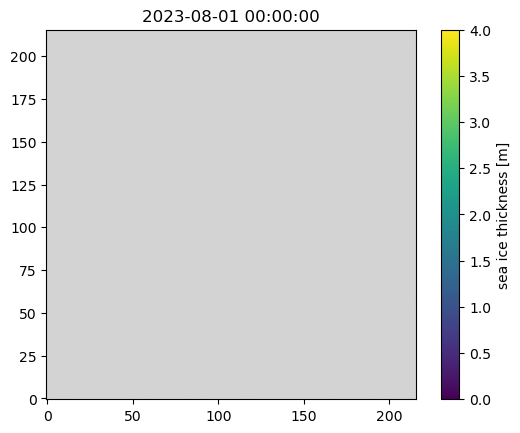

In [60]:
#print(ds.time.values)
idx = 7
import matplotlib.pyplot as plt
im = np.ma.masked_invalid(ds_mo["SIT"].isel(time=idx).values)
cmap = plt.cm.viridis.copy()
cmap.set_bad(color="lightgray")  # NaNs
plt.imshow(im, origin="lower", cmap=cmap, vmin=0, vmax=4)
plt.colorbar(label="sea ice thickness [m]")
plt.title(str(pd.to_datetime(ds_mo.time.values[idx])))
plt.show()

In [ ]:
ds_cci = xr.open_dataset(Path(os.path.expanduser("~/AFIM_archive/ESA_CCI"),"SIT_ESA-CCI_daily_climatology_2002-2012.nc")
SIT_dict["ESA-CCI"] =  {"SIT": ds_cci["SIT"]}
SIT_dict

<xarray.DataArray 'sit_climatology' (clim_time: 366)> Size: 1kB
[366 values with dtype=float32]
Coordinates:
  * clim_time  (clim_time) datetime64[ns] 3kB 2000-01-01 ... 2000-12-31
Attributes:
    long_name:      sea ice thickness daily climatology
    standard_name:  sea_ice_thickness
    units:          m


In [24]:
sim_name    = "elps-min"
dt0_str     = "1994-01-01"
dtN_str     = "1999-12-31"
P_log       = Path(Path.home(), "logs", "paper1_sandbox.log")
SI_tool_mgr = SeaIceToolboxManager(P_log=P_log)
SI_tools = SI_tool_mgr.get_toolbox(sim_name=sim_name, dt0_str=dt0_str, dtN_str=dtN_str)
SI_tools.pygmt_timeseries(SIT_dict, 
                          comp_name   = "SH",
                          primary_key = "SIT",
                          climatology = False,
                          ylabel      = "Sea Ice Thickness (m)",
                          ylim        = [0,4],
                          ytick_pri   = 1,
                          ytick_sec   = .5,
                          show_fig    = True, 
                          legend_pos  = "JTL+jTL+o0.2c+w6c")

2025-08-28 15:51:29,366 - INFO - log file connected: /home/581/da1339/logs/paper1_sandbox.log
2025-08-28 15:51:29,376 - INFO - Dask Client Connected
  Dashboard      : /proxy/8787/status
  Threads        : 5
  Threads/Worker : [1, 1, 1, 1, 1]
  Total Memory   : 35.00 GB

2025-08-28 15:51:29,377 - INFO - hemisphere initialised: SH
2025-08-28 15:51:29,379 - INFO - reading /g/data/gv90/da1339/afim_output/AOM2-ERA5/ice_diag.d to construct /g/data/gv90/da1339/afim_output/AOM2-ERA5/ice_in_AFIM_subset_AOM2-ERA5.json
2025-08-28 15:51:29,381 - INFO -  self.ice_class defined as FI_BT
2025-08-28 15:51:29,383 - INFO - --- SeaIceToolbox Summary ---
2025-08-28 15:51:29,384 - INFO - Simulation Name     : AOM2-ERA5
2025-08-28 15:51:29,385 - INFO - Analysis Start Date : 1994-01-01
2025-08-28 15:51:29,386 - INFO - Analysis End Date   : 1999-12-31
2025-08-28 15:51:29,387 - INFO - Speed Threshold     : 5.0e-04 m/s
2025-08-28 15:51:29,388 - INFO - Speed Type(s)       : BT
2025-08-28 15:51:29,390 - INFO - I

KeyError: 'time'

In [ ]:
lon_bins    = np.arange(-180, 181, 0.25)
lat_bins    = np.arange(-90, -49.75, 0.25)
lon_centers = 0.5 * (lon_bins[:-1] + lon_bins[1:])
lat_centers = 0.5 * (lat_bins[:-1] + lat_bins[1:])
# define the directory to search for download files
D_search = Path(Path.home(),"seaice","ESA_CCI","L2P","envisat","sh")
# recursively search the sub-directory for files that match
F_search = "ESACCI-SEAICE-L2P-SITHICK-RA2_ENVISAT-SH-*-fv2.0.nc"
P_found  = sorted(D_search.rglob(F_search))
print(f"the number of found files = {len(P_found)}")
# open all the files using mfdataset ... this will use about 10GB of memory
SIT      = {}
sit_list = []
for f in tqdm(P_found, desc="Gridding ESA-CCI SIT"):
    ds      = xr.open_dataset(f)
    lon_raw = ds['lon'].values
    lat_raw = ds['lat'].values
    sit_raw = ds['sea_ice_thickness'].values
    valid   = np.isfinite(lon_raw) & np.isfinite(lat_raw) & np.isfinite(sit_raw)
    lon     = lon_raw[valid]
    lat     = lat_raw[valid]
    sit     = sit_raw[valid]
    sit_binned, _, _, _ = binned_statistic_2d(lon, lat, sit, statistic='mean', bins=[lon_bins, lat_bins])
    sit_grid = np.transpose(sit_binned)  # shape: (lat, lon)
    if "time" in ds and ds.time.size > 0:
        time_val = pd.to_datetime(ds.time.values[0]).floor("D")
    else:
        # Fallback: try extracting from filename
        time_str = f.name.split("-")[-2]  # e.g. "20021001"
        time_val = pd.to_datetime(time_str, format="%Y%m%d")
    sit_da   = xr.DataArray(sit_grid[np.newaxis, :, :],
                            dims=("time", "y", "x"),
                            coords={"time": [time_val], "y": lat_centers, "x": lon_centers},
                            name="SIT")
    sit_list.append(sit_da)
ESA_SIT_reG = xr.concat(sit_list, dim='time')
ESA_SIT_reG = ESA_SIT_reG.sel(time=~ESA_SIT_reG.get_index("time").duplicated())
SIT['ESA']  = ESA_SIT_reG.sel(time=slice("2002", "2012")).mean(("x", "y"), skipna=True)
sit_list = []
for i in tqdm(range(len(CICE_SO.time)), desc=f"computing SIT for {afim_name}"):
    hi_t     = CICE_SO['hi'].isel(time=i).load()
    aice_t   = CICE_SO['aice'].isel(time=i).load()
    tarea_t  = CICE_SO['tarea'].isel(time=i).load()
    time_val = pd.to_datetime(CICE_SO.time.values[i]).floor('D')
    sit      = compute_sea_ice_thickness( hi_t, aice_t, tarea_t )
    sit_da   = xr.DataArray(sit.expand_dims('time'), dims="time", coords={"time": [time_val]}, name="SIT")
    sit_list.append(sit_da)
SIT[afim_name] = xr.concat(sit_list, dim='time')
sit_list = []
for i in tqdm(range(len(AOM2_SO.time)), desc=f"computing SIT for {aom2_name}"):
    hi_t     = AOM2_SO['hi'].isel(time=i).load()
    aice_t   = AOM2_SO['aice'].isel(time=i).load()
    tarea_t  = AOM2_SO['tarea'].isel(time=i).load()
    time_val = pd.to_datetime(AOM2_SO.time.values[i]).floor('D')
    sit      = compute_sea_ice_thickness( hi_t, aice_t, tarea_t )
    sit_da   = xr.DataArray(sit.expand_dims('time'), dims="time", coords={"time": [time_val]}, name="SIT")
    sit_list.append(sit_da)
SIT[aom2_name] = xr.concat(sit_list, dim='time')
SIT['ESA']     = SIT['ESA'].assign_coords(doy=SIT['ESA'].time.dt.dayofyear)
SIT[afim_name] = SIT[afim_name].assign_coords(doy=SIT[afim_name].time.dt.dayofyear)
SIT[aom2_name] = SIT[aom2_name].assign_coords(doy=SIT[aom2_name].time.dt.dayofyear)
SIT['ESA_clim']= SIT['ESA'].groupby('doy').mean(dim=('time', 'x', 'y'), skipna=True)
SIT[f"{afim_name}_clim"] = SIT[afim_name].groupby('doy').mean(dim=('time'), skipna=True)
SIT[f"{aom2_name}_clim"] = SIT[aom2_name].groupby('doy').mean(dim=('time'), skipna=True)
SIT.to_netcdf(Path(Path.home(),"AFIM_archive",afim_name,"SIT_sh_comps_v2_2002-2012.nc"))
doy_ticks    = [15, 46, 75, 106, 136, 167, 197, 228, 259, 289, 320, 350]  # ~mid-month
month_labels = pd.to_datetime(doy_ticks, format='%j').strftime('%b')
plt.figure(figsize=(20,12))
plt.plot(SIT['ESA_clim']['doy'], SIT['ESA_clim'].values, label="ESA-CCI", lw=2)
plt.plot(SIT[f'{afim_name}_clim']['doy'], SIT[f'{afim_name}_clim'].values, label=afim_name, lw=2)
plt.plot(SIT[f'{aom2_name}_clim']['doy'], SIT[f'{aom2_mame}_clim'].values, label=aom2_name, lw=2)
plt.xticks(doy_ticks, month_labels, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Month", fontsize=22)
plt.ylabel("Sea Ice Thickness (m)", fontsize=22)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(Path(SI_tools.D_graph,afim_name,"SIT_comparison_and_ESA-CCI.png"))
plt.show()

In [ ]:
# SIT_comps = xr.open_mfdataset("/g/data/gv90/da1339/afim_output/elps-min/SIT_elps-min_*.nc")
# print(SIT_comps)
# ESA_SIT = xr.open_dataset("/g/data/gv90/da1339/SeaIce/ESA_CCI/ESA_CCI_L2P_envisat_SH_SIT_SIV_daily.nc")
# print(ESA_SIT)

In [ ]:
dt                         = pd.to_datetime(SIT_comps["time"].values)
SIT_comps.coords['doy']    = ('time', dt.dayofyear)
SIT_comps['SIT_obs_clim']  = SIT_comps['SIT_obs'].assign_coords(doy=SIT_comps['doy']).groupby('doy').mean('time')
SIT_comps.coords['doy']    = ('time', dt.dayofyear)
SIT_comps['SIT_AOM2_clim'] = SIT_comps['SIT_AOM2'].assign_coords(doy=SIT_comps['doy']).groupby('doy').mean('time')
SIT_comps.coords['doy']    = ('time', dt.dayofyear)
SIT_comps['SIT_CICE_clim'] = SIT_comps['SIT_CICE'].assign_coords(doy=SIT_comps['doy']).groupby('doy').mean('time')

In [ ]:
doy_ticks = [15, 46, 75, 106, 136, 167, 197, 228, 259, 289, 320, 350]  # ~mid-month
month_labels = pd.to_datetime(doy_ticks, format='%j').strftime('%b')
plt.figure(figsize=(20,12))
plt.plot(SIT_comps['doy'], SIT_comps['SIT_obs_clim'].values, label="ESA-CCI", lw=2)
plt.plot(SIT_comps['doy'], SIT_comps['SIT_CICE_clim'].values, label="elps-min", lw=2)
plt.plot(SIT_comps['doy'], SIT_comps['SIT_AOM2_clim'].values, label="AOM2-ERA5", lw=2)
plt.xticks(doy_ticks, month_labels, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Month", fontsize=22)
plt.ylabel("Sea Ice Thickness (m)", fontsize=22)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig(Path(Path.home(),"graphical","AFIM","elps-min", "SIT_comparison_and_ESA-CCI.png"))
plt.show()

In [ ]:
P_ESA_CCI_reG           = Path(Path.home(),"seaice","ESA_CCI","L2P","envisat","sh","reG","ESA_CCI_SIT_regridded.zarr")
ESA_CCI                 = xr.open_zarr(P_ESA_CCI_reG)
dt                      = pd.to_datetime(ESA_CCI["time"].values)
ESA_CCI.coords['doy']   = ('time', dt.dayofyear)
ESA_CCI['ESA_sit_clim'] = ESA_CCI['ESA_sit'].groupby('doy').mean('time')
ESA_CCI['ESA_sit_clim'].sum(dim=['nj','ni']).plot()

In [ ]:
def compute_doy_climatology(da):
    doy = da['time'].dt.dayofyear
    return da.groupby(doy).mean(dim='time', skipna=True)
hi_SO['doy'] = hi_SO.assign_coords(doy=hi_SO['time'].dt.dayofyear)
hi_SO        = hi_SO.chunk({'time': 1, 'nj': 540, 'ni': 720})
hi_SO_clim   = compute_doy_climatology(hi_SO)

sit_CICE_df  = pd.DataFrame({"longitude": CICE_SO.TLON.values.flatten(), "latitude": CICE_SO.TLAT.values.flatten(), "z": hi_SO_clim.isel(dayofyear=180).values.flatten()})
sit_CICE_reG = pygmt.nearneighbor(data=sit_CICE_df, region=[0, 360, -90, -50], spacing="0.25/0.25", search_radius="10k")
sit_CICE_da  = xr.DataArray(sit_CICE_reG.values, coords={"lat": sit_CICE_reG.lat.values, "lon": sit_CICE_reG.lon.values}, dims=("lat", "lon"))


hi_AOM2['doy'] = hi_AOM2.assign_coords(doy=hi_AOM2['time'].dt.dayofyear)
hi_AOM2        = hi_AOM2.chunk({'time': 1, 'nj': 540, 'ni': 720})
hi_AOM2_clim   = compute_doy_climatology(hi_AOM2)
sit_AOM2_df    = pd.DataFrame({"longitude": AOM2_SO.TLON.values.flatten(), "latitude": AOM2_SO.TLAT.values.flatten(), "z": hi_AOM2_clim.isel(dayofyear=180).values.flatten()})
sit_AOM2_reG   = pygmt.nearneighbor(data=sit_AOM2_df, region=[0, 360, -90, -50], spacing="0.25/0.25", search_radius="10k")
sit_AOM2_da    = xr.DataArray(sit_AOM2_reG.values, coords={"lat": sit_AOM2_reG.lat.values, "lon": sit_AOM2_reG.lon.values}, dims=("lat", "lon"))

In [ ]:
ESA_CCI_reG = xr.open_dataset("/home/581/da1339/seaice/ESA_CCI/ESA_CCI_L2P_envisat_SH_SIT_SIV_daily.nc")
ESA_CCI_reG['SIV_clim'].plot()

In [ ]:
def compute_doy_climatology(da):
    return da.groupby(da['time'].dt.dayofyear).mean(dim='time', skipna=True)
def regrid_to_common_grid(lon, lat, z, region=[0, 360, -90, -50], spacing="0.25/0.25", search_radius="10k"):
    df = pd.DataFrame({"longitude": lon.flatten(), "latitude": lat.flatten(), "z": z.flatten()})
    df = df.dropna()
    result = pygmt.nearneighbor(data=df, region=region, spacing=spacing, search_radius=search_radius)
    return xr.DataArray(result.values, coords={"lat": result.lat.values, "lon": result.lon.values}, dims=("lat", "lon"))

# CICE
hi_SO = hi_SO.chunk({'time': 1, 'nj': 540, 'ni': 720})
hi_SO_clim = compute_doy_climatology(hi_SO)

# AOM2
hi_AOM2 = hi_AOM2.chunk({'time': 1, 'nj': 540, 'ni': 720})
hi_AOM2_clim = compute_doy_climatology(hi_AOM2)

# ESA (already climatology from file)
sit_ESA = ESA_CCI_reG['SIT_clim']  # dims: doy, y, x


In [ ]:
from sklearn.metrics import mean_squared_error

metrics = []
reG_sit = {'CICE': [], 'AOM2': [], 'ESA': []}
sit_sum = {'CICE': [], 'AOM2': [], 'ESA': []}

for doy in range(1, 366):
    print(f"\nProcessing DOY: {doy}")
    
    # Extract daily slices
    cice = hi_SO_clim.sel(dayofyear=doy).values
    aom2 = hi_AOM2_clim.sel(dayofyear=doy).values
    esa  = sit_ESA.sel(doy=doy).values

    # Regrid all to common lat/lon
    cice_regrid = regrid_to_common_grid(CICE_SO.TLON.values, CICE_SO.TLAT.values, cice)
    aom2_regrid = regrid_to_common_grid(AOM2_SO.TLON.values, AOM2_SO.TLAT.values, aom2)
    X, Y        = np.meshgrid(sit_ESA.x.values, sit_ESA.y.values)
    esa_regrid  = regrid_to_common_grid(X, Y, esa, search_radius="100k")

    # Store the regridded SIT for future use
    reG_sit['CICE'].append(cice_regrid.expand_dims(doy=[doy]))
    reG_sit['AOM2'].append(aom2_regrid.expand_dims(doy=[doy]))
    reG_sit['ESA'].append(esa_regrid.expand_dims(doy=[doy]))

    # Apply combined valid mask
    valid_mask = ~np.isnan(esa_regrid) & ~np.isnan(cice_regrid) & ~np.isnan(aom2_regrid)
    n_valid = valid_mask.sum().item()
    print(f"Number of valid points: {n_valid}")

    if n_valid < 10:
        print(f"Less than 10 valid data points for DOY {doy} ... skipping")
        continue

    # Flatten valid values
    esa_valid = esa_regrid.values[valid_mask]
    cice_valid = cice_regrid.values[valid_mask]
    aom2_valid = aom2_regrid.values[valid_mask]

    # Spatial sums (sea ice volume proxy)
    sit_sum['CICE'].append((doy, cice_valid.sum().mean()))
    sit_sum['AOM2'].append((doy, aom2_valid.sum().mean()))
    sit_sum['ESA'].append((doy, esa_valid.sum().mean()))

    # Metrics
    rmse_cice = mean_squared_error(esa_valid, cice_valid)
    rmse_aom2 = mean_squared_error(esa_valid, aom2_valid)
    corr_cice = np.corrcoef(esa_valid, cice_valid)[0, 1]
    corr_aom2 = np.corrcoef(esa_valid, aom2_valid)[0, 1]

    metrics.append({
        "DOY": doy,
        "RMSE_CICE": rmse_cice,
        "Corr_CICE": corr_cice,
        "RMSE_AOM2": rmse_aom2,
        "Corr_AOM2": corr_aom2,
        "N": len(esa_valid)
    })

# Create 3D regridded DataArrays
reG_ds = xr.Dataset({
    "ESA": xr.concat(reG_sit["ESA"], dim="doy"),
    "CICE": xr.concat(reG_sit["CICE"], dim="doy"),
    "AOM2": xr.concat(reG_sit["AOM2"], dim="doy"),
})
reG_ds.to_netcdf(Path(Path.home(), "AFIM_archive", "elps-min", "ESA-CCI_daily_SIT_regrid.nc"))

# Create 1D SIT sums
sit_df = pd.DataFrame({
    "DOY": [d for d, _ in sit_sum["ESA"]],
    "ESA_sum": [s for _, s in sit_sum["ESA"]],
    "CICE_sum": [s for _, s in sit_sum["CICE"]],
    "AOM2_sum": [s for _, s in sit_sum["AOM2"]],
})
sit_df = sit_df.set_index("DOY")
sit_ds = sit_df.to_xarray()
sit_ds.to_netcdf(Path(Path.home(), "AFIM_archive", "elps-min", "ESA-CCI_daily_SIT_sum.nc"))

# Metrics dataset
df_metrics = pd.DataFrame(metrics).set_index("DOY")
ds_metrics = df_metrics.to_xarray()
ds_metrics["RMSE_CICE"].attrs = {
    "units": "unitless",
    "long_name": "Root Mean Square Error - CICE model"
}
ds_metrics["Corr_CICE"].attrs = {
    "units": "1",
    "long_name": "Pearson Correlation Coefficient - CICE model"
}
ds_metrics["RMSE_AOM2"].attrs = {
    "units": "unitless",
    "long_name": "Root Mean Square Error - AOM2 model"
}
ds_metrics["Corr_AOM2"].attrs = {
    "units": "1",
    "long_name": "Pearson Correlation Coefficient - AOM2 model"
}
ds_metrics["N"].attrs = {
    "units": "count",
    "long_name": "Number of spatial grid points used"
}
ds_metrics.attrs = {
    "title": "Daily Model Skill Metrics",
    "summary": "Daily statistics comparing CICE and AOM2 model outputs against ESA-CCI observations.",
    "Conventions": "CF-1.8",
    "source": "Generated using xarray from Python",
    "author": "Dan Atwater",
}
ds_metrics.to_netcdf(Path(Path.home(), "AFIM_archive", "elps-min", "ESA-CCI_daily_metrics.nc"))

print("All NetCDF files written successfully.")


In [ ]:
# Plot RMSE comparison
plt.figure(figsize=(10, 5))
plt.plot(ds.DOY, ds.RMSE_CICE, label="RMSE - CICE")
plt.plot(ds.DOY, ds.RMSE_AOM2, label="RMSE - AOM2")
plt.xlabel("Day of Year")
plt.ylabel("RMSE")
plt.title("Daily RMSE for CICE and AOM2 Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Correlation comparison
plt.figure(figsize=(10, 5))
plt.plot(ds.DOY, ds.Corr_CICE, label="Correlation - CICE")
plt.plot(ds.DOY, ds.Corr_AOM2, label="Correlation - AOM2")
plt.xlabel("Day of Year")
plt.ylabel("Correlation Coefficient")
plt.title("Daily Correlation for CICE and AOM2 Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
sim_name = "elps-min"
#for region in SI_tools.Ant_8sectors.keys():
SI_tools = SeaIceToolbox(sim_name=sim_name)
D_png = Path(SI_tools.D_graph, sim_name, "south", "hi")
D_ani = Path(SI_tools.D_graph, "animations", sim_name, "hi")
F_ani = f"{sim_name}_hi_south.mp4"
P_ani = Path(D_ani,F_ani)
P_mp4 = Path.home() / "AFIM" / "src" / "AFIM" / "docs" / "figures" / F_ani
D_ani.mkdir(parents=True, exist_ok=True)
frames = sorted([f for f in os.listdir(D_png) if f.endswith(".png")])
os.system(f"rm {SI_tools.D_tmp}/frame_*.png")
for i, f in enumerate(frames):
    src = D_png / f
    dst = Path(SI_tools.D_tmp) / f"frame_{i:04d}.png"
    if not dst.exists():
        os.symlink(src, dst)
os.system(f"ffmpeg -y -r 2 -i {SI_tools.D_tmp}/frame_%04d.png -vf \"scale=iw:ih+mod(2-ih\\,2)\" -c:v libx264 -pix_fmt yuv420p {P_ani}")
os.system(f"cp {P_ani} {P_mp4}")

In [ ]:
CICE_SO     = CICE.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
sim_name    = "AOM2-ERA5"
dt0_str     = "1993-01-01"
dtN_str     = "1999-12-31"
SI_tools    = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           overwrite_zarr       = True,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)
DS, AOM2    = SI_tools.load_processed_cice(zarr_CICE = True)
AOM2_SO     = AOM2.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
OSI_SAF     = xr.open_mfdataset("/home/581/da1339/seaice/OSI_SAF/ispd_reG_SH*")

In [ ]:
from PIL import Image
def stitch_fip_side_by_side(sim_model, sim_obs, base_dir, region_list, output_path, dpi=200):
    nrows = len(region_list)
    fig, axs = plt.subplots(nrows=nrows, ncols=3, figsize=(20,60))
    for row, region in enumerate(region_list):
        for col, sim in enumerate([sim_obs, sim_model, "FIP_delta"]):  # left: obs, right: model
            if col==2:
                path = os.path.join(base_dir, sim_model, region, "FIP_delta", f"2000-2018_{sim_model}_{region}_FIP_delta.png")
            else:
                path = os.path.join(base_dir, sim, region, "FIP", f"2000-2018_{sim}_{region}_FIP.png")
            if not os.path.exists(path):
                print(f"❌ Missing: {path}")
                axs[row, col].axis("off")
                continue
            img = Image.open(path)
            axs[row, col].imshow(img)
            axs[row, col].axis("off")
    axs[0, 0].set_title("AF2020 (obs)"       , fontsize=14, fontweight="bold")
    axs[0, 1].set_title(f"{sim_model} (sim)" , fontsize=14, fontweight="bold")
    axs[0, 2].set_title("Difference: obs-sim", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.savefig(output_path, dpi=dpi)
    plt.close()
    print(f"✅ Saved stitched figure: {output_path}")
region_list = ["DML", "WIO", "EIO", "Aus", "VOL", "AS", "BS", "WS"]
stitch_fip_side_by_side("elps-min", "AF20",
                  base_dir="/g/data/gv90/da1339/GRAPHICAL/AFIM",
                  region_list=region_list,
                  output_path="/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIP_panel_AF20_vs_elps-min.png")

In [ ]:
def convert_stats_dict_to_xarray(stats_dict):
    sim_names = list(stats_dict.keys())
    scalar_vars = {}
    for sim in sim_names:
        for metric_group, metrics in stats_dict[sim].items():
            if isinstance(metrics, xr.DataArray):  # skip time series here
                continue
            for metric_name, value in metrics.items():
                var_key = f"{metric_group}_{metric_name}".replace(" ", "_").replace("-", "_")
                if var_key not in scalar_vars:
                    scalar_vars[var_key] = []
                scalar_vars[var_key].append(value)
    scalar_da_dict = {key: xr.DataArray(data=np.array(vals),
                                        dims=["simulation"],
                                        coords={"simulation": sim_names},
                                        name=key) for key, vals in scalar_vars.items()}
    time_series_da = {}
    for var_name in ['SIA', 'SIV']:
        ts_list = []
        for sim in sim_names:
            da = stats_dict[sim].get(var_name)
            if da is None:
                raise ValueError(f"Missing {var_name} for {sim}")
            da = da.expand_dims({"simulation": [sim]})
            da = da.chunk({"time": 180})  # uniform rechunking
            ts_list.append(da)
        time_series_da[var_name] = xr.concat(ts_list, dim="simulation")
    ds = xr.Dataset({**scalar_da_dict, **time_series_da})
    return ds

def extract_skill_metrics(stats_dict, group="SIA_skills"):
    """
    Extract skill metrics (e.g., Bias, RMSE, Corr, etc.) for each simulation.
    Returns a DataFrame with simulations as rows and skill metrics as columns.
    """
    rows = []
    for sim, sim_dict in stats_dict.items():
        metrics = sim_dict.get(group, {})
        rows.append(pd.Series(metrics, name=sim))
    return pd.DataFrame(rows)

def extract_seasonal_stats_df(ds, prefix="SIA_season"):
    """
    Extract tidy DataFrame of mean/std seasonal stats from an xarray.Dataset,
    matching variable names in a case-insensitive way.
    """
    import re
    records = []
    prefix_lower = prefix.lower()
    for var in ds.data_vars:
        var_lower = var.lower()
        if var_lower.startswith(prefix_lower) and var_lower.endswith("_mean"):
            # Extract metric name (e.g., "growth") from original var
            base = var[len(prefix) + 1:-5]  # preserve original case
            std_var_candidates = [v for v in ds.data_vars if v.lower() == f"{prefix.lower()}_{base.lower()}_std"]
            if std_var_candidates:
                std_var = std_var_candidates[0]
                for sim in ds.simulation.values:
                    records.append({
                        "Simulation": sim,
                        "Metric": base.replace("_", " "),  # optional: format name
                        "Mean": ds[var].sel(simulation=sim).item(),
                        "Std": ds[std_var].sel(simulation=sim).item()
                    })
    return pd.DataFrame.from_records(records)

def normalise_columnwise(df, signed_cols=None):
    """
    Normalise all columns to [0, 1], but handle `signed_cols` (e.g., Bias) using symmetric scaling to [-1, 1] → rescale to [0, 1].
    """
    df_norm = df.copy()
    signed_cols = signed_cols or []
    for col in df.columns:
        if col in signed_cols:
            max_abs = df[col].abs().max()
            df_norm[col] = (df[col] / max_abs + 1) / 2  # maps [-max, max] → [0, 1]
        else:
            df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df_norm

def format_heatmap_annotations(df, digits_dict):
    """
    Format the values of df using digits_dict, e.g., {'Bias': 2, 'Corr': 3}
    """
    formatted = df.copy().astype(str)
    for col in df.columns:
        digits = digits_dict.get(col, 2)
        formatted[col] = df[col].apply(lambda x: f"{x:.{digits}f}")
    return formatted

def plot_skill_heatmap(df_skills, normalise=False, cmap="viridis", P_png=None):
    import seaborn as sns
    digits_dict = {"Bias": 3,
                   "RMSE": 3,
                   "MAE" : 3,
                   "Corr": 3,
                   "SD_Model": 3,
                   "SD_Obs": 3}
    annot_df = format_heatmap_annotations(df_skills, digits_dict)
    df_plot = df_skills.copy()
    if normalise:
        df_plot = normalize_columnwise(df_skills, signed_cols=["Bias"])
    else:
        df_plot = df_skills.copy()
    plt.figure(figsize=(12, len(df_plot) * 0.4))
    sns.heatmap(df_plot, annot=annot_df.values, fmt="", cmap=cmap, cbar=True, linewidths=0.5 )
    #plt.title("Skill Metrics by Simulation" + (" (Normalised)" if normalise else ""))
    plt.ylabel("Simulation")
    plt.xlabel("Metric")
    plt.tight_layout()
    if P_png:
        plt.savefig(P_png)
    plt.show()


def plot_grouped_seasonal_stats(df, ncols=4, height=4, palette="Blues_d", var_type="SIA", P_png=None):
    """
    Plot grouped seasonal stats with error bars using manual subplots.
    
    Parameters
    ----------
    df : DataFrame
        Must contain columns ["Simulation", "Metric", "Mean", "Std"]
    ncols : int
        Number of subplot columns.
    height : float
        Height per subplot.
    palette : str
        Seaborn color palette.
    var_type : str
        One of ["SIA", "SIV", "FIA", "FIV"] to determine y-labels and unit scaling.
    """
    import seaborn as sns
    ylim_dict = {
        ("SIA", "maximum"): (15, 19),
        ("SIA", "minimum"): (0, 2),
        ("SIA", "growth"): (6, 10),
        ("SIA", "retreat"): (-15, -10),
        ("SIA", "duration"): (280, 310),
        ("SIA", "doy min"): (50, 70),
        ("SIA", "doy max"): (225, 275),
        ("SIA", "doy onset"): (50, 70),
    }
    # Filter out unwanted metrics
    df = df[~df["Metric"].isin(["retreat Early", "retreat Late"])]

    metrics = df["Metric"].unique()
    nplots = len(metrics)
    nrows = int(np.ceil(nplots / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * height), sharex=False)
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        sub = df[df["Metric"] == metric].copy()

        # Determine metric display name and units
        metric_lower = metric.lower()
        if metric in ["Growth", "retreat"]:
            metric_name = f"{metric.lower()} rate"
            if var_type in ["SIA", "SIV"]:
                sub["Mean"] = sub["Mean"] / 1e4
                sub["Std"] = sub["Std"] / 1e4
                ylabel = "10^4 km²/day" if var_type == "SIA" else "10⁶ km³/day"
            else:
                ylabel = "10^3 km²/day" if var_type == "FIA" else "10³ km³/day"
        elif metric in ["Maximum", "Minimum"]:
            metric_name = f"{metric.lower()} {var_type}"
            if var_type in ["SIA", "SIV"]:
                ylabel = "10⁶ km²" if var_type == "SIA" else "10⁶ km³"
            else:
                ylabel = "10³ km²" if var_type == "FIA" else "10³ km³"
        elif "duration" in metric_lower or "doy" in metric_lower:
            metric_name = metric_lower.replace("_", " ")
            ylabel = "Day of Year"
        else:
            metric_name = metric.lower()
            ylabel = "Value"

        # Plot
        ax = axes[i]
        sns.barplot(data=sub, x="Simulation", y="Mean", ax=ax, palette=palette)
        ax.errorbar(
            x=np.arange(len(sub)),
            y=sub["Mean"],
            yerr=sub["Std"],
            fmt='none',
            c='k',
            capsize=4,
            lw=1.2
        )
        ax.set_title(metric_name, fontsize=12)
        ax.set_ylabel(ylabel)
        for label in ax.get_xticklabels():
            label.set_rotation(90)

        # Apply custom ylim if matched
        metric_clean = metric_name.lower().strip().replace("_", " ")
        key = (var_type, metric_clean.split()[0]) if "doy" not in metric_clean else (var_type, metric_clean)
        if key in ylim_dict:
            ax.set_ylim(ylim_dict[key])

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    #fig.suptitle(f"{var_type} Seasonal Statistics Across Simulations", fontsize=16, y=1.02)
    plt.tight_layout()
    if P_png:
        plt.savefig(P_png)
    plt.show()

In [ ]:
# Define file pattern and sort files
file_pattern = "/g/data/jk72/af1544/fraser2020_data/FastIce_70_*.nc"
nc_files = sorted(glob.glob(file_pattern))
# Pre-allocate results
all_fia = []
all_time = []

In [ ]:
# Loop through each file, compute FIA for each time step
for file in tqdm(nc_files, desc="processing observed FIA"):
    ds = xr.load_dataset(file, engine="netcdf4", decode_times=True)
    area = ds['area'].values  # shape (Y, X)
    time_values = pd.to_datetime(ds['time'].values)  # this is safe and idempotent
    for t in range(ds.dims['time']):
        mask = (ds['Fast_Ice_Time_series'].isel(time=t).values >= 4).astype("uint8")
        fia_obs = (mask * area).sum()/1e3
        all_fia.append(fia_obs)
        all_time.append(time_values[t])

In [ ]:
# Construct time series DataFrame
fia_series = pd.Series(all_fia, index=pd.to_datetime(all_time))
fia_series.name = "AF2020"

In [ ]:
# Ensure it's a pandas Series with a datetime index
FIA_series = fia_series.sort_index()  # just in case
daily_index = pd.date_range(start = FIA_series.index.min(),
                            end   = FIA_series.index.max(),
                            freq  = 'D')
FIA_daily = FIA_series.reindex(daily_index).interpolate(method='akima')
FIA_daily_xr = xr.DataArray(FIA_daily, dims="time", coords={"time": daily_index})
FIA_daily_xr.name = "AF2020"  # give the DataArray a name for NetCDF variable
FIA_daily_xr.attrs["units"] = "1000-km²"
FIA_daily_xr.attrs["long_name"] = "Daily-Interpolated ('akima') Circum-Antarctic Fast Ice Area (AF2020)"
FIA_ds = xr.Dataset({"AF2020": FIA_daily_xr})
FIA_ds.to_netcdf("/g/data/gv90/da1339/SeaIce/FI_obs/FIA_AF2020_daily.nc")


In [ ]:
def format_stats_table(all_stats_dict):
    records = []
    for sim_name, stats in all_stats_dict.items():
        if sim_name=="AF2020":
            continue
        row = {}
        for stat_key, value in stats.items():
            if stat_key in ['FIA','FIV','FIT','FIP']:
                continue
            row[stat_key] = float(value.values)
        row["Simulation"] = sim_name
        records.append(row)
    df_stats = pd.DataFrame(records).set_index("Simulation")
    df_stats = df_stats.sort_index()  # optional: alphabetical sort
    return df_stats

In [ ]:
df = format_stats_table(FIP_dict)
print(df.to_string(float_format="%.5f"))

In [ ]:
df = format_stats_table(FIA_dict)
print(df.T.to_string(float_format="%.2f"))

In [ ]:
df = format_stats_table(FIV_dict)
print(df.T.to_string(float_format="%.2f"))

In [ ]:
df = format_stats_table(FIT_dict)
print(df.T.to_string(float_format="%.4f"))

In [ ]:
def compute_annual_fia_stats(fia_dict):
    """
    Compute annual max, min, and mean FIA and interannual variability metrics for each simulation.

    Parameters
    ----------
    fia_dict : dict
        Dictionary containing simulations, each with an xarray.DataArray under key 'FIA'.

    Returns
    -------
    annual_stats_df : pd.DataFrame
        DataFrame with annual FIA stats (mean of annual max, std of annual max, etc.) for each simulation.
    annual_series_dict : dict
        Dict of annual max FIA time series for each simulation.
    """
    annual_series_dict = {}
    summary_records = []

    for sim_name, sim_data in fia_dict.items():
        if sim_name == "AF2020":
            continue  # skip climatology for now

        da = sim_data.get("FIA", None)
        if da is None or "time" not in da.coords:
            continue

        # Compute annual statistics
        annual_max = da.groupby("time.year").max(skipna=True)
        annual_min = da.groupby("time.year").min(skipna=True)
        annual_mean = da.groupby("time.year").mean(skipna=True)

        # Store the annual max time series
        annual_series_dict[sim_name] = annual_max

        # Compute summary stats
        record = {
            "Simulation": sim_name,
            "Max_Mean": float(annual_max.mean().values),
            "Max_Std": float(annual_max.std().values),
            "Min_Mean": float(annual_min.mean().values),
            "Min_Std": float(annual_min.std().values),
            "Mean_Mean": float(annual_mean.mean().values),
            "Mean_Std": float(annual_mean.std().values),
        }
        summary_records.append(record)

    df_summary = pd.DataFrame.from_records(summary_records).set_index("Simulation")
    return df_summary, annual_series_dict


In [ ]:
stats = compute_annual_fia_stats(FIA_dict)